<a href="https://colab.research.google.com/github/suparuek2405/Stock-screening-with-python/blob/main/Group_assignment_Tacocat_set_yfinance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install libraries
# !pip install pandas
# !pip install numpy
# !pip install yfinance

In [2]:
#import library
import yfinance as yf
import pandas as pd
import numpy as np
from google.colab import drive
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 300  # Set the default DPI to 300
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning, message="Converting to PeriodArray/Index representation will drop timezone information.")

### This part is for retrive data, skip if already got data



In [3]:
#Function for get data from yfinance
def rename_columns_to_year_end(df):
    df_rt = df.copy()
    years = df_rt.columns.year
    year_end_dates = [pd.Timestamp(f"{year}-12-31") for year in years]
    df_rt.columns = year_end_dates
    return df_rt

def get_balance_sheet(ticker):
  balance_sheet_df = pd.DataFrame()
  n = len(ticker)
  print("start getting balance sheet")
  for c,i in enumerate(ticker):
    #retrive data from yfinance
    stock = yf.Ticker(i)
    raw = stock.balancesheet

    #rename column
    bs = rename_columns_to_year_end(raw)

      #reset index and rename it
    bs.reset_index(inplace=True)
    bs.rename(columns={'index': 'data'}, inplace=True)
    bs['symbol'] = i.split('.')[0]

    # Check for duplicates in the 'data' column and drop them
    bs = bs[~bs.duplicated(subset=['data'])]
    bs.set_index(['symbol', 'data'], inplace=True)

    #change type data of column for better look
    bs.columns = pd.to_datetime(bs.columns)

    #append to dataframe
    balance_sheet_df = pd.concat([balance_sheet_df, bs])
    print(f"{c+1}/{n} {i}")
  print("finish getting balance sheet")
  return balance_sheet_df

def get_income_statement(ticker):
  income_statement_df = pd.DataFrame()
  n = len(ticker)
  print("start getting income statement")
  for c,i in enumerate(ticker):
    #retrive data from yfinance
    stock = yf.Ticker(i)
    raw = stock.financials

    #rename column
    is_df = rename_columns_to_year_end(raw)

    #reset index and rename it
    is_df.reset_index(inplace=True)
    is_df.rename(columns={'index': 'data'}, inplace=True)
    is_df['symbol'] = i.split('.')[0]

    # Check for duplicates in the 'data' column and drop them
    is_df = is_df[~is_df.duplicated(subset=['data'])]
    is_df.set_index(['symbol', 'data'], inplace=True)

    #change type data of column for better look
    is_df.columns = pd.to_datetime(is_df.columns)

    #append to dataframe
    income_statement_df = pd.concat([income_statement_df, is_df])
    print(f"{c+1}/{n} {i}")
  print("finish getting income statement")
  return income_statement_df

def get_cashflow_statement(ticker):
  cashflow_statement_df = pd.DataFrame()
  n = len(ticker)
  print("start getting cashflow statement")
  for c,i in enumerate(ticker):
    #retrive data from yfinance
    stock = yf.Ticker(i)
    raw = stock.cashflow

    #rename column
    cf_df = rename_columns_to_year_end(raw)

    #reset index and rename it
    cf_df.reset_index(inplace=True)
    cf_df.rename(columns={'index': 'data'}, inplace=True)
    cf_df['symbol'] = i.split('.')[0]

    # Check for duplicates in the 'data' column and drop them
    cf_df = cf_df[~cf_df.duplicated(subset=['data'])]
    cf_df.set_index(['symbol', 'data'], inplace=True)

    #change type data of column for better look
    cf_df.columns = pd.to_datetime(cf_df.columns)

    #append to dataframe
    cashflow_statement_df = pd.concat([cashflow_statement_df, cf_df])
    print(f"{c+1}/{n} {i}")
  print("finish getting cashflow statement")
  return cashflow_statement_df

def get_monthly_stock_prices(ticker,start_date = "2022-01-01", end_date="2024-09-30"):
  stock = yf.Ticker(ticker)
  data = stock.history(start=start_date, end=end_date, interval="1mo")
  data = data.set_index(pd.to_datetime(data.index))

  # Resample to the start of each month
  monthly_prices = data['Close'].resample('MS').first()
  monthly_prices = pd.DataFrame(monthly_prices)
  monthly_prices['symbol'] = ticker.split('.')[0]
  monthly_prices.index = monthly_prices.index.to_period('M').to_timestamp(how='start')
  return monthly_prices

def get_dividend_data(ticker, start_date="2022-01-01", end_date="2024-09-30"):
  stock = yf.Ticker(ticker)
  dividends = stock.dividends
  # Filter dividends based on the specified date range
  dividends = dividends[(dividends.index >= start_date) & (dividends.index <= end_date)]
  if not dividends.empty:
    dividends_df = pd.DataFrame(dividends)
    dividends_df['symbol'] = ticker.split('.')[0]
    dividends_df = dividends_df.rename(columns={'Dividends':'amount'})
    dividends_df.index = dividends_df.index.to_period('M').to_timestamp(how='start')
    return dividends_df

def get_financial_data(ticker):
  balance_sheet = get_balance_sheet(ticker)
  income_statement = get_income_statement(ticker)
  cashflow_statement = get_cashflow_statement(ticker)
  return balance_sheet, income_statement, cashflow_statement

In [4]:
#df = pd.read_csv('/content/drive/My Drive/Tools/Group Assignment/set_scraped.csv')
df = pd.read_csv('https://raw.githubusercontent.com/suparuek2405/Stock-screening-with-python/main/set_scraped.csv')

In [5]:
bkk = df.copy()
bkk = bkk[['symbol', 'text-start', 'text-start 2', 'symbol 2', 'symbol 3']]
bkk.columns = ['symbol', 'company_name', 'market', 'industry', 'sector']
bkk['ticker'] = bkk['symbol'] + '.BK'

In [6]:
set_list = bkk['ticker']
ticker_error = ['DIMET.BK'] #exclude error ticker
set_list = set_list[set_list.isin(ticker_error) == False]

In [7]:
#run this code to start retrive data from yfinance
bl_st, ic_st, cf_st = get_financial_data(set_list)

In [8]:
# run this code below to download file
# bl_st.to_csv('balance_sheet.csv')
# ic_st.to_csv('income_statement.csv')
# cf_st.to_csv('cashflow_statement.csv')

# from google.colab import files
# files.download('balance_sheet.csv')
# files.download('income_statement.csv')
# files.download('cashflow_statement.csv')

-------------------------

### After get data


In [9]:
#do not change variable name due to function using these as global variable
df = pd.read_csv('https://raw.githubusercontent.com/suparuek2405/Stock-screening-with-python/main/set_scraped.csv')
bkk = df.copy()
bkk = bkk[['symbol', 'text-start', 'text-start 2', 'symbol 2', 'symbol 3']]
bkk.columns = ['symbol', 'company_name', 'market', 'industry', 'sector']
bkk['ticker'] = bkk['symbol'] + '.BK'
bl = pd.read_csv('https://raw.githubusercontent.com/suparuek2405/Stock-screening-with-python/refs/heads/main/balance_sheet.csv')
ic = pd.read_csv('https://raw.githubusercontent.com/suparuek2405/Stock-screening-with-python/refs/heads/main/income_statement.csv')
cf = pd.read_csv('https://raw.githubusercontent.com/suparuek2405/Stock-screening-with-python/refs/heads/main/cashflow_statement.csv')

### Function for plot return on investment and detail by symbol

In [10]:
#Function for visualize data
def get_return_on_investment(list_of_stock, money=1000000, start_date='2023-03-01', end_date='2024-10-01'):
  n = len(list_of_stock)
  buy = money/n
  port = pd.DataFrame()
  for stock in list_of_stock:
    symbol = stock+".BK"

    #calculate capital gain
    df = get_monthly_stock_prices(symbol, start_date, end_date)
    start_price = df.iloc[0].values[0]
    df['share'] = buy/start_price
    df['stock_values'] = df['Close']*df['share']

    #calculate dividend paid
    dvd = get_dividend_data(symbol, start_date, end_date)
    if dvd is None:
      m = df[['share', 'stock_values']].copy()
      m['dividend_pay_per_share'] = 0
      dvd = m
    else:
      dvd = dvd.pivot_table(index=dvd.index, values='amount', aggfunc='sum', fill_value=0)
      dvd.rename(columns={'amount': 'dividend_pay_per_share'}, inplace=True)

    #combine capital gain and dividend paid
    df = pd.merge(df, dvd[['dividend_pay_per_share']], on='Date', how='left')
    df['dividend_pay_per_share'] = df['dividend_pay_per_share'].fillna(0)
    df['dividend_paid'] = df['dividend_pay_per_share'] * df['share']
    df['accumulate_dividend'] = df['dividend_paid'].cumsum()
    df['total_values'] = df['stock_values'] + df['accumulate_dividend']

    #add to port
    port = pd.concat([port, df[['symbol','Close','share','stock_values','accumulate_dividend','total_values']]])

  return port

def calculate_return(port):
  df = port.reset_index().copy()
  df = df.melt(id_vars=['Date','symbol'], value_vars=['stock_values', 'accumulate_dividend']).set_index('Date')
  df.rename(columns={'variable': 'type of gain', 'value': 'THB'}, inplace=True)
  df.index = pd.to_datetime(df.index)
  return df

def format_y_axis_mil(y, pos):
    return f'{y/1000000:.2f}'

def format_y_axis_k(y, pos):
    return f'{y/1000:.0f}'

def plot_overall_return(port, name, money=1000000):
  fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

  #add first subplot > stock values
  df1 = port[port['type of gain'] == 'stock_values']
  sns.lineplot(x=df1.index, y='THB', data=df1, estimator='sum', errorbar=None, ax=axes[0], marker='.')
  axes[0].xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically adjusts the ticks
  axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))  # Custom date format (Year-Month)

  # Rotate and adjust the x-tick labels
  # plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
  axes[0].set_xlabel('')
  axes[0].set_ylabel('Million baht')
  axes[0].yaxis.set_major_formatter(FuncFormatter(format_y_axis_mil))

  #padding axis
  monthly_sum_df1 = df1.resample('ME').sum()
  current_min_mil = monthly_sum_df1['THB'].min()
  current_max_mil = monthly_sum_df1['THB'].max()
  axes[0].set_ylim(current_min_mil * 0.95, current_max_mil * 1.075)  # Add 10% padding

  # Annotate each point on the first subplot
  for line in axes[0].lines:
    for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
      axes[0].annotate(f'{y_value/1000000:.2f}', (x_value, y_value),
                       textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)
  # add title
  start = df1.loc[min(df1.index)]['THB'].sum()
  end = df1.loc[max(df1.index)]['THB'].sum()
  gain = end-start
  percent = (end-start)/start*100
  axes[0].set_title(f'Capital gain = {gain:,.0f} THB, %Capital gain = {percent:.1f}%')

  #add second subplot > dividend values
  df2 = port[port['type of gain'] == 'accumulate_dividend']
  sns.lineplot(x=df2.index, y='THB', data=df2, estimator='sum', errorbar=None, ax=axes[1])
  axes[1].xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically adjusts the ticks
  axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))  # Custom date format (Year-Month)

  # Rotate and adjust the x-tick labels
  # plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
  axes[1].set_xlabel('')
  axes[1].set_ylabel('Thousand baht')
  axes[1].yaxis.set_major_formatter(FuncFormatter(format_y_axis_k))

  #padding axis
  monthly_sum_df2 = df2.resample('ME').sum()
  current_min_k = monthly_sum_df2['THB'].min()
  current_max_k = monthly_sum_df2['THB'].max()
  axes[1].set_ylim(current_min_k * 0.95, current_max_k * 1.075)  # Add 10% padding

  # Annotate each point on the second subplot
  for line in axes[1].lines:
    for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
      axes[1].annotate(f'{y_value/1000:.2f}', (x_value, y_value),
                       textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

  # add title
  dividend = df2.loc[max(df2.index)]['THB'].sum()
  dividend_yield = dividend/money
  axes[1].set_title(f'Accumulated dividend = {dividend:,.0f} THB, Total dividend yield = {dividend_yield*100:.1f}%')

  # Adjust layout and display
  tl = port.loc[max(port.index)]['THB'].sum()
  tl_gain = tl-money
  tl_roi = tl_gain/money*100
  plt.suptitle(f'Overall Return ({name}), Total return = {tl_gain:,.0f}, ROI = {tl_roi:.1f}%', fontsize=16)
  plt.tight_layout()

def plot_roi(list_of_stock, name, money=1000000, start_date='2023-03-01', end_date='2024-10-01'):
  port = get_return_on_investment(list_of_stock, money, start_date, end_date)
  x = calculate_return(port)
  plot_overall_return(x, name, money)

def display_overall_return_by_stock(x, name, money=1000000):
  df = x.pivot_table(index=[x.index,'symbol'], columns='type of gain', values='THB', aggfunc='sum').reset_index()
  df.set_index('Date', inplace=True)
  start = df.loc[df.index.min()].set_index('symbol')
  end = df.loc[df.index.max()].set_index('symbol')

  #merge start and end
  merged_df = start.merge(end, on='symbol', suffixes=('_start', '_end'))
  merged_df['capital gain'] = merged_df['stock_values_end'] - merged_df['stock_values_start']
  merged_df['%capital gain'] = merged_df['capital gain'] / merged_df['stock_values_start']
  merged_df['%accumulated dividend yield'] = merged_df['accumulate_dividend_end'] / merged_df['stock_values_start']
  merged_df['total return'] = merged_df['capital gain'] + merged_df['accumulate_dividend_end']
  merged_df['ROI'] = merged_df['total return'] / merged_df['stock_values_start']
  merged_df.rename(columns={'stock_values_start':'initial portfolio', 'stock_values_end':'current portfolio', 'accumulate_dividend_end':'accumulated dividend'}, inplace=True)
  rt = merged_df[['initial portfolio', 'current portfolio', 'capital gain', '%capital gain','accumulated dividend', '%accumulated dividend yield', 'total return', 'ROI']]

  # Ensure the index is datetime
  df.index = pd.to_datetime(df.index)

  # Format the start and end dates
  start_date = df.index.min().strftime('%b %Y')  # e.g., Mar 2023
  end_date = df.index.max().strftime('%b %Y')  # e.g., Sep 2024

  # Calculate the difference in years and months
  date_diff = relativedelta(df.index.max(), df.index.min())
  years = date_diff.years
  months = date_diff.months

  # Construct the output
  print(f'Summary of investment by symbol ({name})')
  print(f'start invest from {start_date} to {end_date} (total time: {years} year {months} months)')
  rt.columns.name = None
  rt = rt.sort_values(by='ROI', ascending=False)

  # Applying the formatting
  df_style = (rt.style
      .format({
          'initial portfolio': '{:,.0f}',
          'current portfolio': '{:,.0f}',
          'capital gain': '{:,.0f}',
          '%capital gain': '{:.1%}',
          'accumulated dividend': '{:,.0f}',
          '%accumulated dividend yield': '{:.1%}',
          'total return': '{:,.0f}',
          'ROI': '{:.1%}'
      })
              )

  display(df_style)

def display_summary(list_of_stock, name, money = 1000000):
  port = get_return_on_investment(list_of_stock)
  x = calculate_return(port)
  display_overall_return_by_stock(x, name, money)

### Function for Growth investment style

In [11]:
def get_lastdateofyear(start_year, end_year):
    last_dates = []

    for year in range(start_year, end_year + 1):
        last_date = datetime(year, 12, 31).strftime('%Y-%m-%d')
        last_dates.append(last_date)

    return last_dates

def get_roe(startyear=2020, endyear=2022):
  #get lastdate of year to retrive
  col = get_lastdateofyear(startyear, endyear)

  #create copy of data to calculate
  net_income = ic[ic.data == 'Net Income'][['symbol', 'data'] + col].copy()
  stockholder_equity = bl[bl.data == 'Stockholders Equity'][['symbol', 'data'] + col].copy()

  #merge table
  df_merge = pd.merge(net_income, stockholder_equity, on='symbol', suffixes=('_ni', '_se'))

  # Calculate ROE: Net Income / Average Stockholders' Equity
  roe_dict = {}
  for year in col:
      # Calculate ROE: Net Income / Stockholders' Equity
      df_merge[f'{year}'] = df_merge[f'{year}_ni'] / df_merge[f'{year}_se']

      # Store the ROE results for the year in the dictionary
      roe_dict[f'{year}'] = df_merge[[f'{year}']]

  #prep return dataframe
  df = df_merge[['symbol'] + [f'{year}' for year in col]].copy()
  df['ratio'] = "ROE"

  return df[['symbol', 'ratio'] + col]

def get_revenue_growth_yoy(startyear=2020, endyear=2022):
  col = get_lastdateofyear(startyear, endyear)
  revenue = ic[ic.data == 'Total Revenue'][['symbol', 'data'] + col].copy()

  revenue_growth_dict = {}
  for i in range(len(col) - 1):
    current_year = col[i + 1]
    previous_year = col[i]
    revenue[f'{current_year}_growth'] = (revenue[current_year] - revenue[previous_year]) / revenue[previous_year]

    # Store the revenue growth results for the year in the dictionary
    revenue_growth_dict[f'{current_year}_growth'] = revenue[[f'{current_year}_growth']]

  # Prepare the return DataFrame
  df = revenue[['symbol'] + [f'{year}_growth' for year in col[1:]]].copy()
  df['ratio'] = 'Revenue Growth YOY'

  # Rename columns by removing the '_growth' suffix
  df.rename(columns={f'{year}_growth': f'{year}' for year in col[1:]}, inplace=True)

  return df[['symbol', 'ratio'] + [f'{year}' for year in col[1:]]]

def get_net_profit_margin(startyear=2020, endyear=2022):
  #get lastdate of year to retrive
  col = get_lastdateofyear(startyear, endyear)

  #create copy of data to calculate
  net_income = ic[ic.data == 'Net Income'][['symbol', 'data'] + col].copy()
  total_revenue = ic[ic.data == 'Total Revenue'][['symbol', 'data'] + col].copy()

  #merge table
  df_merge = pd.merge(net_income, total_revenue, on='symbol', suffixes=('_ni', '_tr'))

  # Calculate Net Profit Margin: Net Income / Total Revenue
  npm_dict = {}
  for year in col:
      # Calculate Net Profit Margin: Net Income / Total Revenue
      df_merge[f'{year}'] = df_merge[f'{year}_ni'] / df_merge[f'{year}_tr']

      # Store the Net Profit Margin results for the year in the dictionary
      npm_dict[f'{year}'] = df_merge[[f'{year}']]

  #prep return dataframe
  df = df_merge[['symbol'] + [f'{year}' for year in col]].copy()
  df['ratio'] = "Net Profit Margin"

  return df[['symbol', 'ratio'] + col]

def get_roa(startyear=2020, endyear=2022):
  # Get the last date of each year
  col = get_lastdateofyear(startyear, endyear)

  # Create copies of the dataframes for calculation
  net_income = ic[ic.data == 'Net Income'][['symbol', 'data'] + col].copy()
  total_assets = bl[bl.data == 'Total Assets'][['symbol', 'data'] + col].copy()

  # Merge the two dataframes on the 'symbol' column
  df_merge = pd.merge(net_income, total_assets, on='symbol', suffixes=('_ni', '_ta'))

  # Calculate ROA for each year and store the results in a dictionary
  roa_dict = {}
  for year in col:
    # Calculate ROA: Net Income / Total Assets
    df_merge[f'{year}'] = df_merge[f'{year}_ni'] / df_merge[f'{year}_ta']

    # Store the ROA results for the year in the dictionary
    roa_dict[f'{year}'] = df_merge[[f'{year}']]

  # Prepare the return dataframe
  df = df_merge[['symbol'] + [f'{year}' for year in col]].copy()
  df['ratio'] = "ROA"

  return df[['symbol', 'ratio'] + col]

def get_operating_cashflow_growth(startyear=2020, endyear=2022):
  col = get_lastdateofyear(startyear, endyear)
  operating_cashflow = cf[cf.data == 'Operating Cash Flow'][['symbol', 'data'] + col].copy()

  ocf_growth_dict = {}
  for i in range(len(col) - 1):
    current_year = col[i + 1]
    previous_year = col[i]
    operating_cashflow[f'{current_year}_growth'] = (operating_cashflow[current_year] - operating_cashflow[previous_year]) / operating_cashflow[previous_year]

    # Store the operating cash flow growth results for the year in the dictionary
    ocf_growth_dict[f'{current_year}_growth'] = operating_cashflow[[f'{current_year}_growth']]

  # Prepare the return DataFrame
  df = operating_cashflow[['symbol'] + [f'{year}_growth' for year in col[1:]]].copy()
  df['ratio'] = 'Operating Cash Flow Growth YOY'

  # Rename columns by removing the '_growth' suffix
  df.rename(columns={f'{year}_growth': f'{year}' for year in col[1:]}, inplace=True)

  return df[['symbol', 'ratio'] + [f'{year}' for year in col[1:]]]

def get_de(startyear=2020, endyear=2022):
  # Get the last date of each year
  col = get_lastdateofyear(startyear, endyear)

  # Create copies of the dataframes for calculation
  total_debt = bl[bl.data == 'Total Debt'][['symbol', 'data'] + col].copy()
  stockholder_equity = bl[bl.data == 'Stockholders Equity'][['symbol', 'data'] + col].copy()

  # Merge the two dataframes on the 'symbol' column
  df_merge = pd.merge(total_debt, stockholder_equity, on='symbol', suffixes=('_td', '_se'))

  # Calculate D/E Ratio for each year and store the results in a dictionary
  de_dict = {}
  for year in col:
    # Calculate D/E Ratio: Total Debt / Stockholders' Equity
    df_merge[f'{year}'] = df_merge[f'{year}_td'] / df_merge[f'{year}_se']

    # Store the D/E Ratio results for the year in the dictionary
    de_dict[f'{year}'] = df_merge[[f'{year}']]

  # Prepare the return dataframe
  df = df_merge[['symbol'] + [f'{year}' for year in col]].copy()
  df['ratio'] = "D/E Ratio"

  return df[['symbol', 'ratio'] + col]

### First plot - Financial Ratios screening for Growth Investment #1

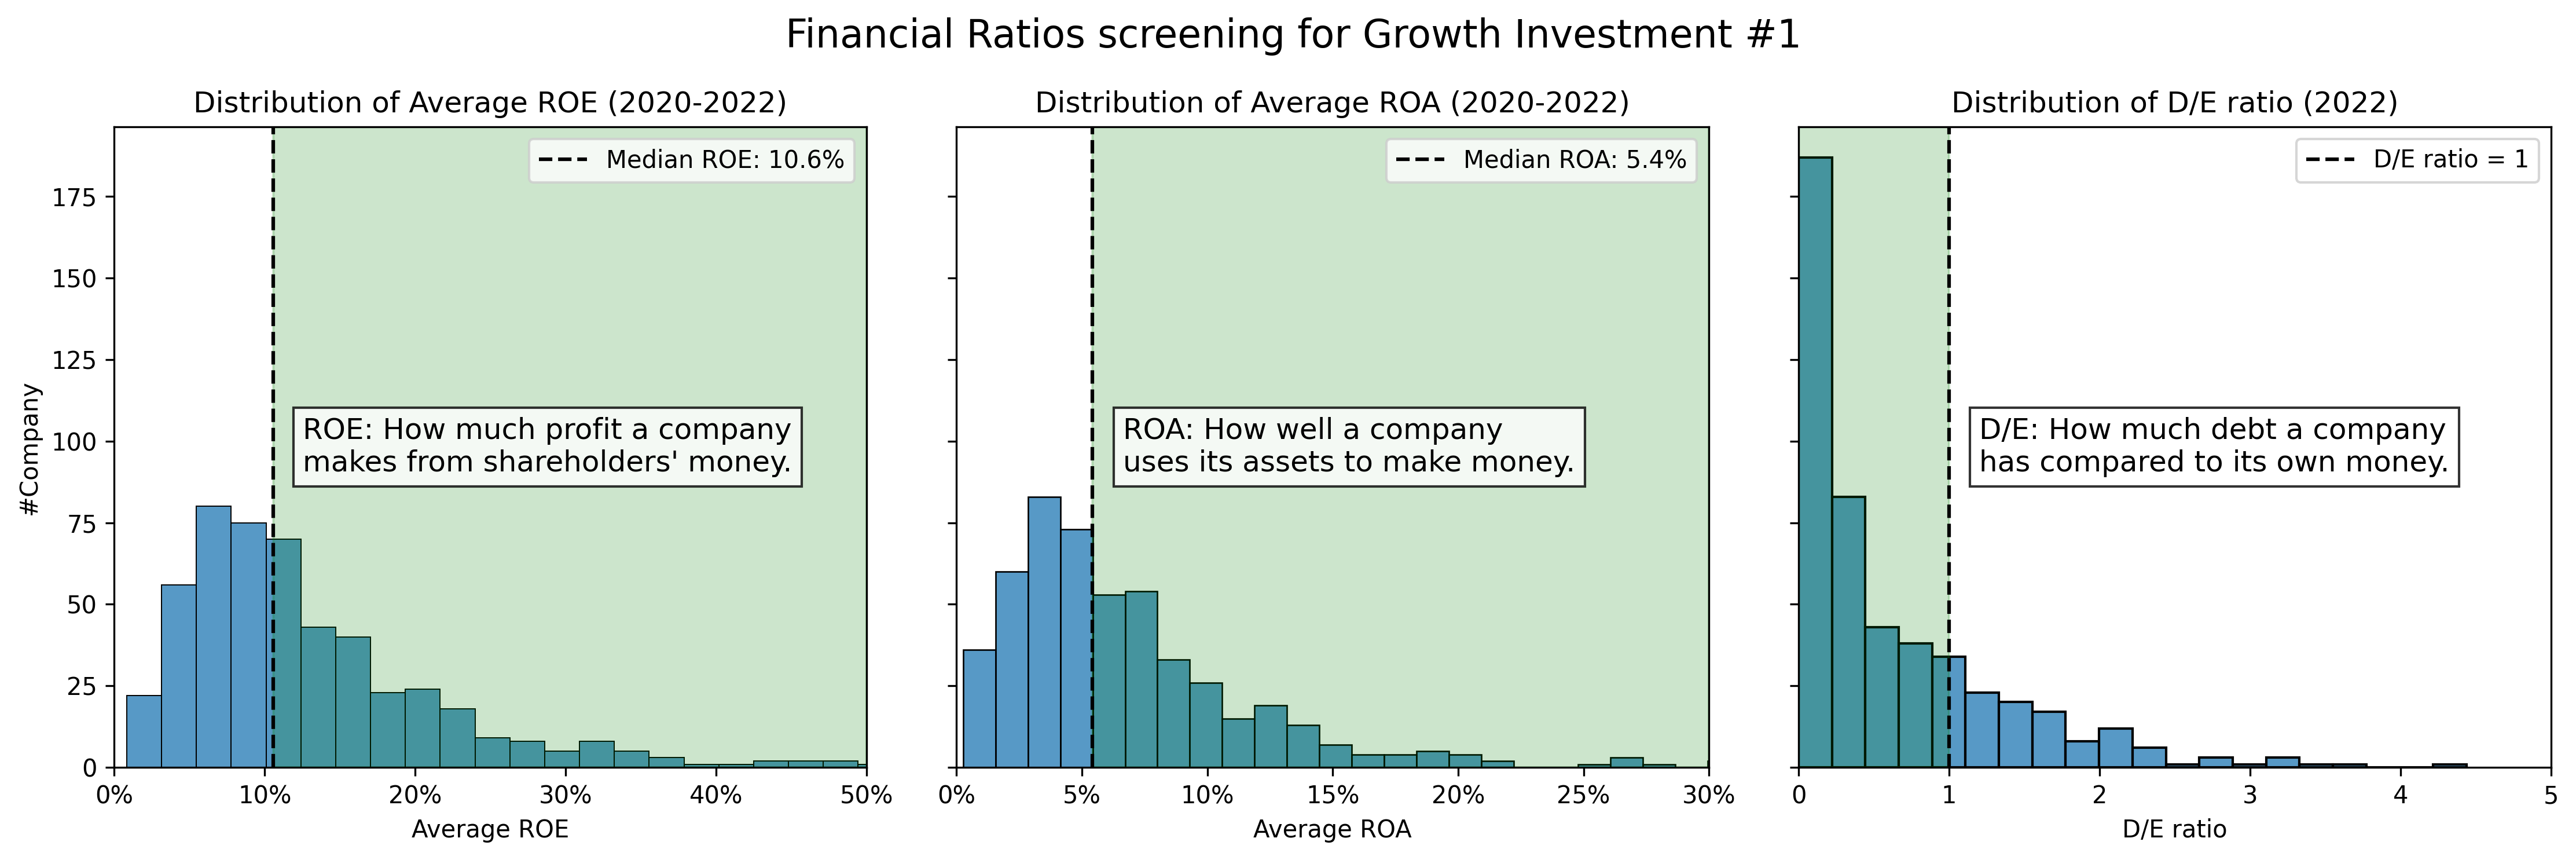

In [12]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

# Condition for ROE
roe = get_roe(2020,2022) #using data from 2022 to 2024
roe.dropna(inplace=True) #drop na values
roe = roe[(roe[['2020-12-31', '2021-12-31', '2022-12-31']] > 0).all(axis=1)] #all value must greater than 0
roe['avg_roe_3year'] = roe[['2020-12-31', '2021-12-31', '2022-12-31']].mean(axis=1) #get average ROE of 3 years

# Plot ROE distribution on the first subplot
sns.histplot(x='avg_roe_3year', data=roe, ax=axes[0])
median_roe = roe['avg_roe_3year'].median()
axes[0].axvline(median_roe, color='black', linestyle='--', label=f'Median ROE: {median_roe*100:.1f}%')
axes[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
axes[0].set_title('Distribution of Average ROE (2020-2022)')
axes[0].set_xlabel('Average ROE')
axes[0].set_ylabel('#Company')
axes[0].set_xlim(0, 0.5)
axes[0].legend()

# Condition for ROA
roa = get_roa(2020,2022) #using data from 2020 to 2022
roa.dropna(inplace=True) #drop na values
roa = roa[(roa[['2020-12-31', '2021-12-31', '2022-12-31']] > 0).all(axis=1)] #all value must greater than 0
roa['avg_roa_3year'] = roa[['2020-12-31', '2021-12-31', '2022-12-31']].mean(axis=1) #get average 3 year
roa = roa[roa['symbol'].isin(set(roe['symbol']))] #filter only symbol contains in roe table

# Plot ROA distribution on the second subplot
sns.histplot(x='avg_roa_3year', data=roa, ax=axes[1])
median_roa = roa['avg_roa_3year'].median()
axes[1].axvline(median_roa, color='black', linestyle='--', label=f'Median ROA: {median_roa*100:.1f}%')
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
axes[1].set_title('Distribution of Average ROA (2020-2022)')
axes[1].set_xlabel('Average ROA')
axes[1].set_ylabel('#Company')
axes[1].set_xlim(0, 0.3)
axes[1].legend()

# Condition for DE
de = get_de(2022) #using data only 2022
de.dropna(inplace=True) #drop na values
de = de[(de[['2022-12-31']] <= 5).all(axis=1) & (de[['2022-12-31']] > 0).all(axis=1)] #filter outlier
de = de[de['symbol'].isin(set(roa['symbol']))] #filter only symbol contains in roa table

# Plot D/E ratio distribution on the third subplot
sns.histplot(x='2022-12-31', data=de, ax=axes[2])
de_line = 1
axes[2].axvline(de_line, color='black', linestyle='--', label=f'D/E ratio = 1')
axes[2].set_title('Distribution of D/E ratio (2022)')
axes[2].set_xlabel('D/E ratio')
axes[2].set_ylabel('#Company')
axes[2].set_xlim(0, 5)
axes[2].legend()

#add highlight and textbox
y_min, y_max = axes[0].get_ylim()

axes[0].set_ylim(0, y_max)
axes[0].fill_betweenx(y=[y_min, y_max], x1=median_roe, x2=axes[0].get_xlim()[1], color='green', alpha=0.2)
axes[0].text(median_roe + (axes[0].get_xlim()[1] - median_roe) * 0.05, (y_min+y_max)/2,
             'ROE: How much profit a company\nmakes from shareholders\' money.',
             color='black', fontsize=12, bbox=dict(facecolor='white', alpha=0.8),
             ha='left', va='center')

axes[1].set_ylim(0, y_max)
axes[1].fill_betweenx(y=[y_min, y_max], x1=median_roa, x2=axes[1].get_xlim()[1], color='green', alpha=0.2)
axes[1].text(median_roa + (axes[1].get_xlim()[1] - median_roa) * 0.05, (y_min+y_max)/2,
             'ROA: How well a company\nuses its assets to make money.',
             color='black', fontsize=12, bbox=dict(facecolor='white', alpha=0.8),
             ha='left', va='center')

axes[2].set_ylim(0, y_max)
axes[2].fill_betweenx(y=[y_min, y_max], x1=axes[2].get_xlim()[0], x2=de_line, color='green', alpha=0.2)
axes[2].text(de_line + (axes[2].get_xlim()[1] - de_line) * 0.05, (y_min+y_max)/2,
             'D/E: How much debt a company\nhas compared to its own money.',
             color='black', fontsize=12, bbox=dict(facecolor='white', alpha=0.8),
             ha='left', va='center')

# Adjust the layout and display the plot
plt.suptitle('Financial Ratios screening for Growth Investment #1', fontsize=16)
plt.tight_layout()
plt.show()

### Second plot - Financial Ratios screening for Growth Investment #2

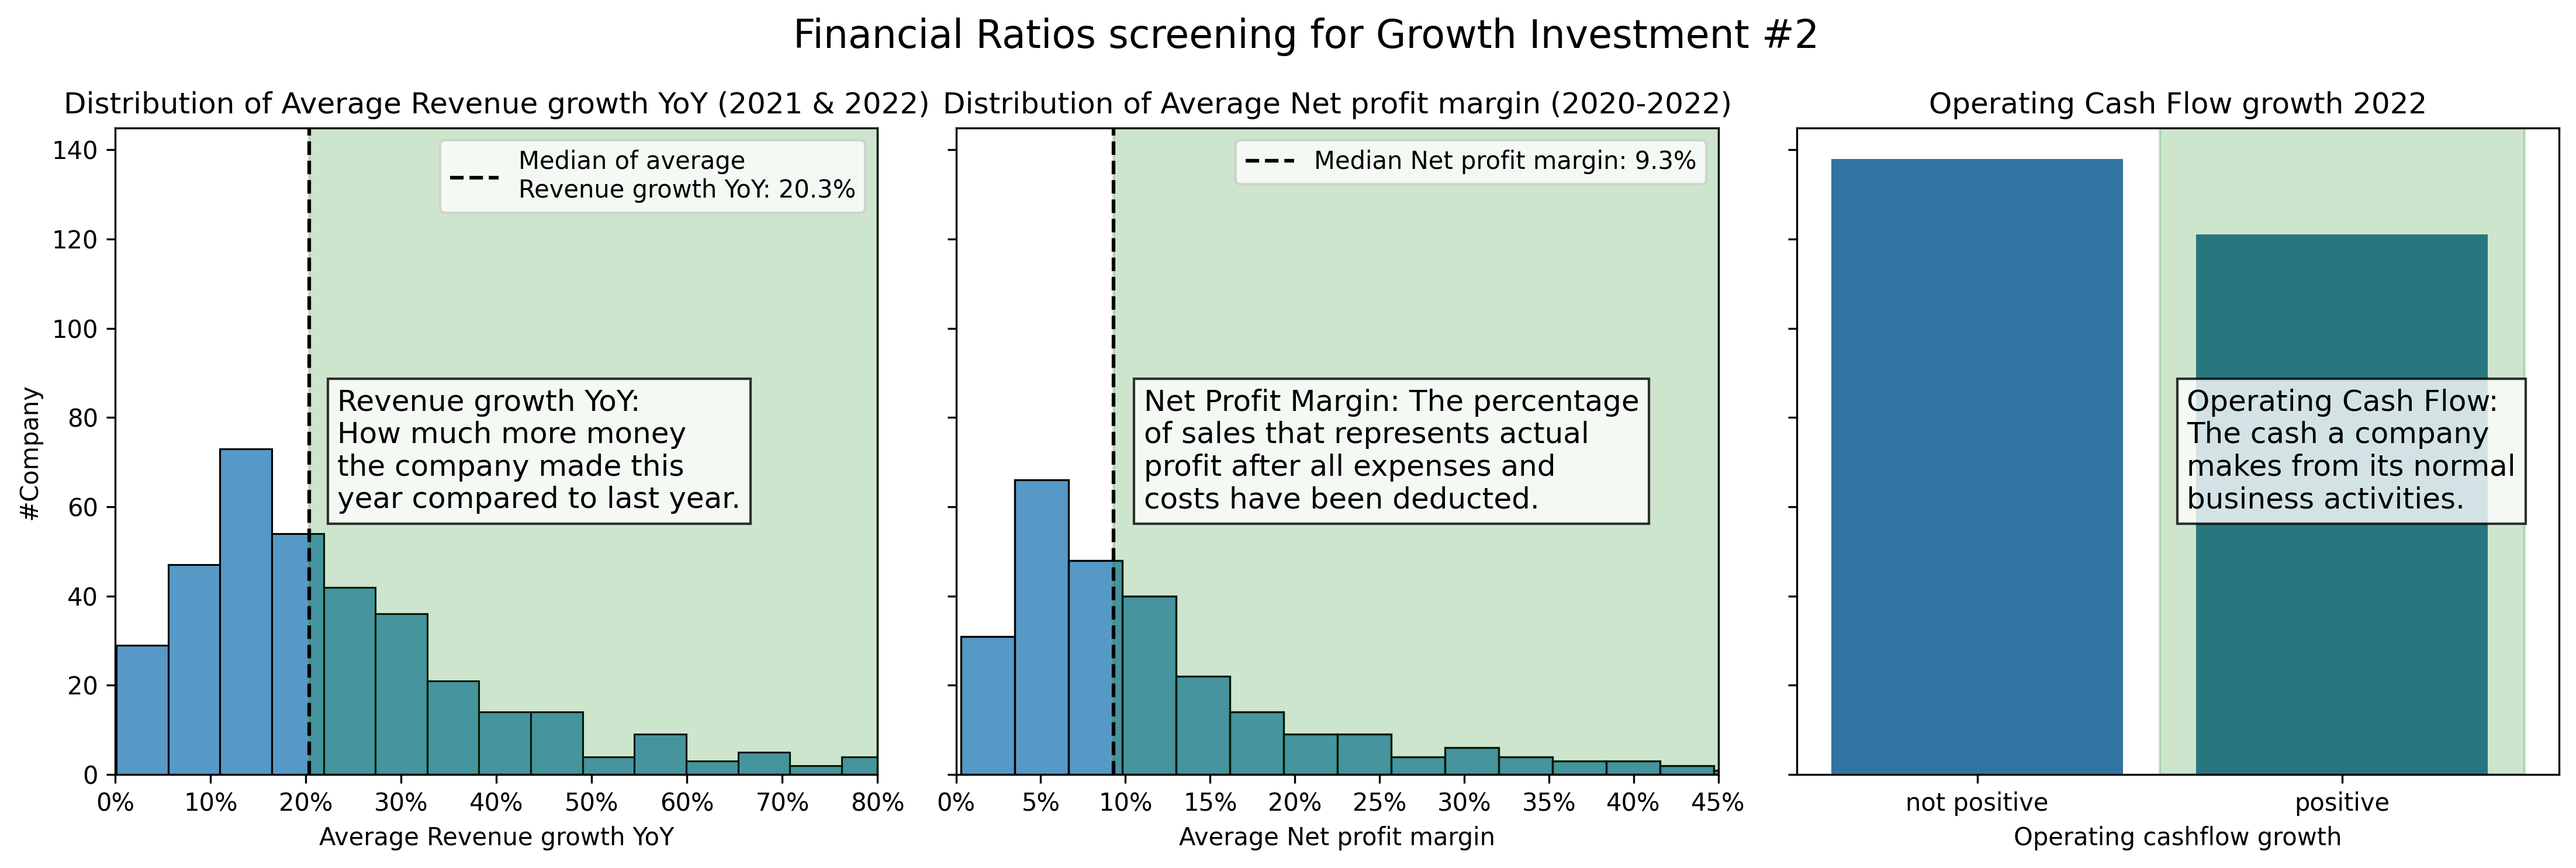

In [13]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

# Condition for revenue growth
rev_gth = get_revenue_growth_yoy(2020,2022)
rev_gth.dropna(inplace=True) #drop na values
rev_gth = rev_gth[(rev_gth[['2021-12-31', '2022-12-31']] > 0).all(axis=1) & (rev_gth[['2021-12-31', '2022-12-31']] < 2).all(axis=1)] #filter value more than 0 but less than 2
rev_gth['rev_gth_2year'] = rev_gth[['2021-12-31', '2022-12-31']].mean(axis=1) #get average 2 year

# Plot revenue growth distribution on the first subplot
sns.histplot(x='rev_gth_2year', data=rev_gth, ax=axes[0])
median_gth = rev_gth['rev_gth_2year'].median()
axes[0].axvline(median_gth, color='black', linestyle='--', label=f'Median of average\nRevenue growth YoY: {median_gth*100:.1f}%')
axes[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
axes[0].set_title('Distribution of Average Revenue growth YoY (2021 & 2022)')
axes[0].set_xlabel('Average Revenue growth YoY')
axes[0].set_ylabel('#Company')
axes[0].set_xlim(0, 0.8)
axes[0].legend()

# Condition for NPM
npm = get_net_profit_margin(2020,2022)
npm.dropna(inplace=True) #drop na values
npm = npm[(npm[['2020-12-31', '2021-12-31', '2022-12-31']] > 0).all(axis=1)] #all value must greater than 0
npm['avg_npm_3year'] = npm[['2020-12-31', '2021-12-31', '2022-12-31']].mean(axis=1) #get average 3 year
npm = npm[npm['symbol'].isin(set(rev_gth['symbol']))] #filter only symbol contains in rev_gth table

# Plot NPM distribution on the second subplot
sns.histplot(x='avg_npm_3year', data=npm, ax=axes[1])
median_npm = npm['avg_npm_3year'].median()
axes[1].axvline(median_npm, color='black', linestyle='--', label=f'Median Net profit margin: {median_npm*100:.1f}%')
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
axes[1].set_title('Distribution of Average Net profit margin (2020-2022)')
axes[1].set_xlabel('Average Net profit margin')
axes[1].set_ylabel('#Company')
axes[1].set_xlim(0, 0.45)
axes[1].legend()

# Condition for operating cashflow
oper = get_operating_cashflow_growth(2020,2022)
oper.dropna(inplace=True) #drop na values
###oper['2 years consecutive growth'] = ((oper['2021-12-31'] > 0) & (oper['2022-12-31'] > 0)).apply(lambda x: 'positive' if x else 'not positive')
oper['2022 oper cashflow growth'] = ((oper['2022-12-31'] > 0)).apply(lambda x: 'positive' if x else 'not positive')
oper = oper[oper['symbol'].isin(set(npm['symbol']))] #filter only symbol contains in npm table

# Plot operating cashflow distribution on the third subplot
###sns.countplot(x='2 years consecutive growth', data=oper, ax=axes[2], order=['not positive', 'positive'])
sns.countplot(x='2022 oper cashflow growth', data=oper, ax=axes[2], order=['not positive', 'positive'])
axes[2].set_title('Distribution of Operating Cash Flow Growth')
axes[2].set_xlabel('Operating cashflow growth')
axes[2].set_ylabel('#Company')
###axes[2].set_title('Operating Cash Flow Growth (2021 & 2022)')
axes[2].set_title('Operating Cash Flow growth 2022')

#add highlight and textbox
y_min, y_max = axes[0].get_ylim()

axes[0].set_ylim(0, y_max)
axes[0].fill_betweenx(y=[y_min, y_max], x1=median_gth, x2=axes[0].get_xlim()[1], color='green', alpha=0.2)
axes[0].text(median_gth + (axes[0].get_xlim()[1] - median_gth) * 0.05, (y_min+y_max)/2,
             'Revenue growth YoY:\nHow much more money\nthe company made this\nyear compared to last year.',
             color='black', fontsize=12, bbox=dict(facecolor='white', alpha=0.8),
             ha='left', va='center')

axes[1].set_ylim(0, y_max)
axes[1].fill_betweenx(y=[y_min, y_max], x1=median_npm, x2=axes[1].get_xlim()[1], color='green', alpha=0.2)
axes[1].text(median_npm + (axes[1].get_xlim()[1] - median_npm) * 0.05, (y_min+y_max)/2,
             'Net Profit Margin: The percentage\nof sales that represents actual \nprofit after all expenses and\ncosts have been deducted.',
             color='black', fontsize=12, bbox=dict(facecolor='white', alpha=0.8),
             ha='left', va='center')

# Highlight the area for the positive category
x_pos = axes[2].get_xticks()
axes[2].axvspan(x_pos[1] - 0.5, x_pos[1] + 0.5, color='green', alpha=0.2)
axes[2].text(0.5 + (axes[2].get_xlim()[1] - median_npm) * 0.05, (y_min+y_max)/2,
             'Operating Cash Flow:\nThe cash a company\nmakes from its normal\nbusiness activities.',
             color='black', fontsize=12, bbox=dict(facecolor='white', alpha=0.8),
             ha='left', va='center')

# Adjust the layout and display the plot
plt.suptitle('Financial Ratios screening for Growth Investment #2', fontsize=16)
plt.tight_layout()
plt.show()

### Third plot - Financial Ratios screening for Growth Investment #3

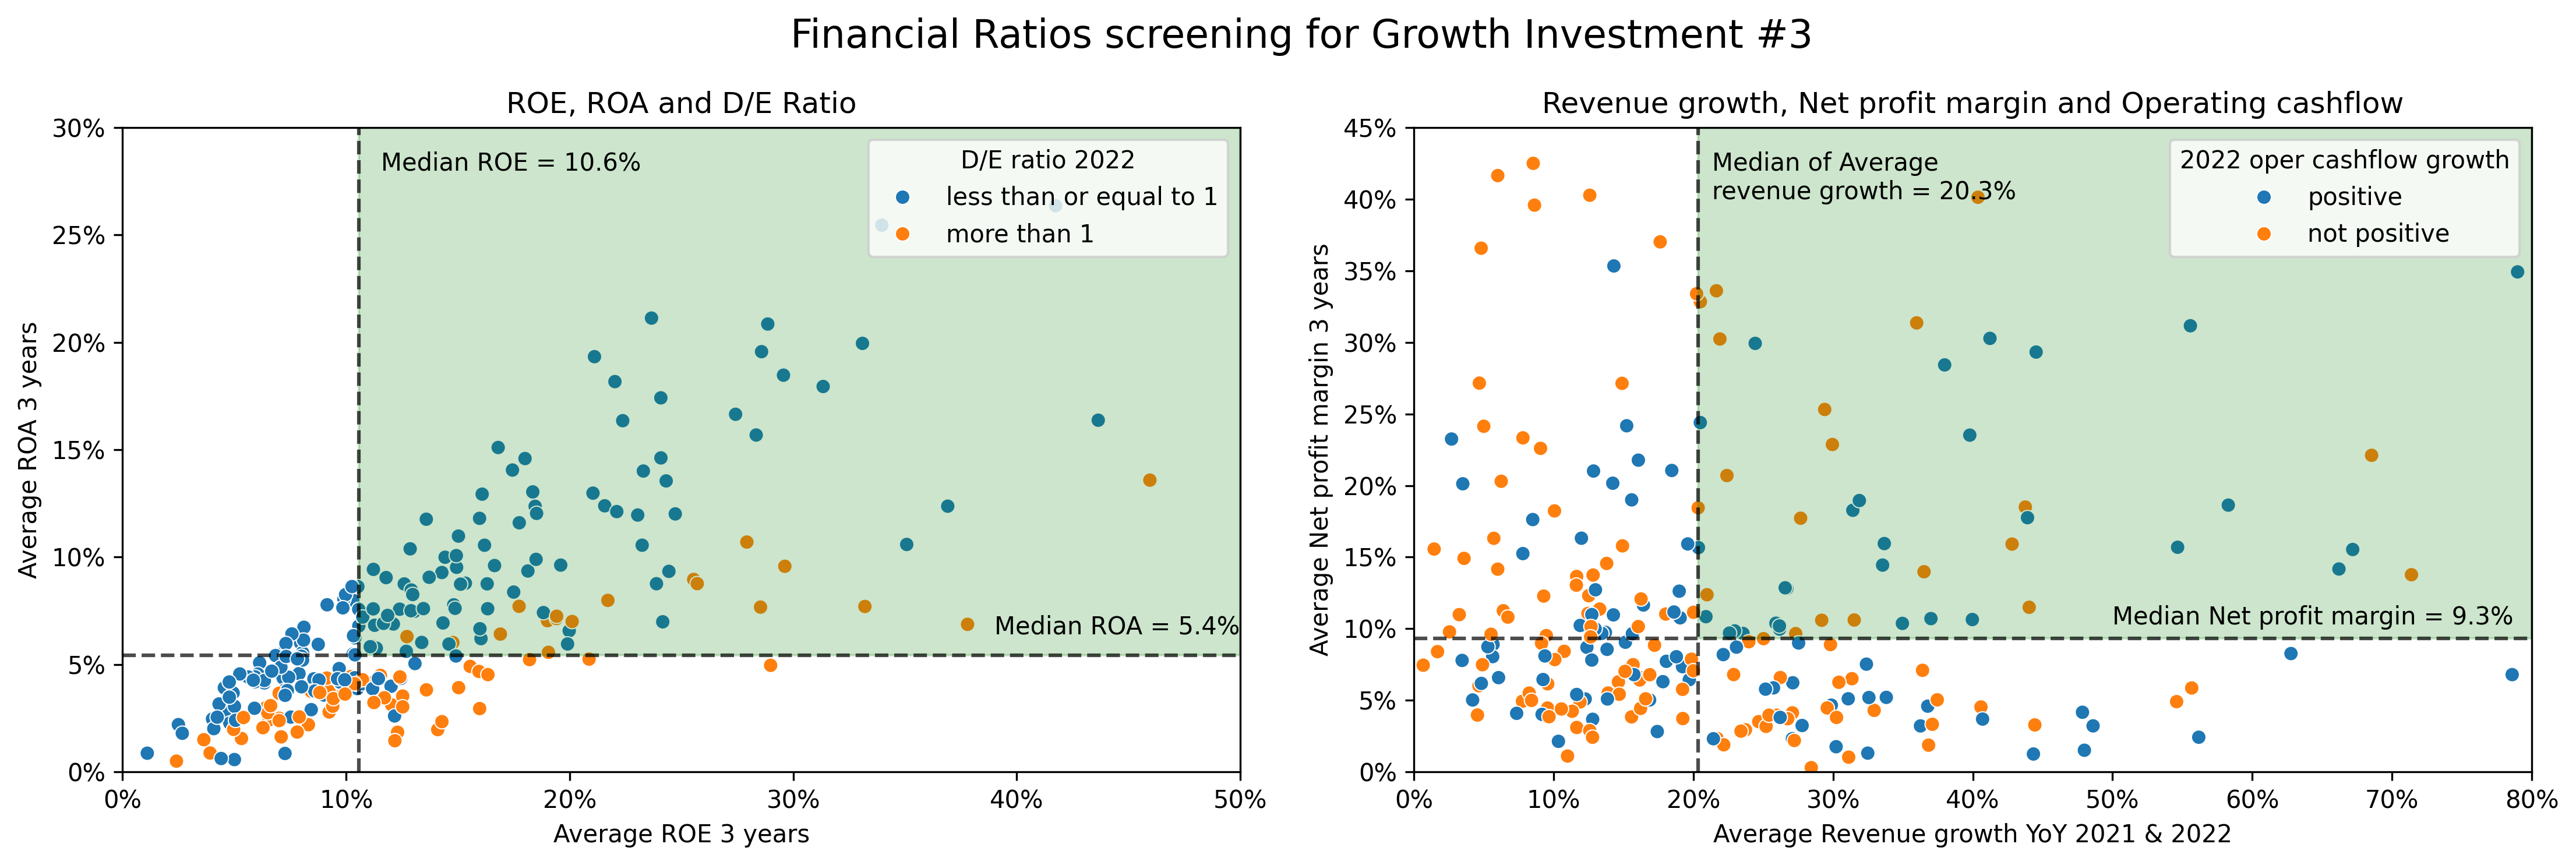

In [14]:
#combine all data
a = roe[['symbol', 'avg_roe_3year']].copy()
b = roa[['symbol','avg_roa_3year']].copy()
c = de[['symbol', '2022-12-31']].copy()
c = de[['symbol', '2022-12-31']].copy()
c['de2022'] = c['2022-12-31'].apply(lambda x: 'less than or equal to 1' if x <= 1 else 'more than 1')
c = c[['symbol', 'de2022']]
d = rev_gth[['symbol', 'rev_gth_2year']].copy()
e = npm[['symbol', 'avg_npm_3year']].copy()
###f = oper[['symbol', '2 years consecutive growth']].copy()
f = oper[['symbol', '2022 oper cashflow growth']].copy()

#combine a to f with inner join
df_merged = pd.merge(a, b, on='symbol', how='inner') \
             .merge(c, on='symbol', how='inner') \
             .merge(d, on='symbol', how='inner') \
             .merge(e, on='symbol', how='inner') \
             .merge(f, on='symbol', how='inner')

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#add first subplot
sns.scatterplot(x='avg_roe_3year', y='avg_roa_3year', hue='de2022', data=df_merged, ax=axes[0])

#adjust axis
axes[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
axes[0].set_xlim(0,0.5)
axes[0].set_ylim(0,0.3)
axes[0].set_xlabel('Average ROE 3 years')
axes[0].set_ylabel('Average ROA 3 years')
axes[0].set_title('ROE, ROA and D/E Ratio')
axes[0].axvline(x=median_roe, color='black', linestyle='--',alpha=0.7)
axes[0].axhline(y=median_roa, color='black', linestyle='--',alpha=0.7)
axes[0].legend(loc='upper right', title='D/E ratio 2022')
axes[0].text(median_roe + 0.01, 0.28, f'Median ROE = {median_roe*100:.1f}%', color='black')
axes[0].text(0.39, median_roa + 0.01, f'Median ROA = {median_roa*100:.1f}%', color='black')
axes[0].fill_betweenx(y=[median_roa, 0.3], x1=median_roe, x2=0.5, color='green', alpha=0.2)

#add second subplot
###sns.scatterplot(x='rev_gth_2year', y='avg_npm_3year', hue='2 years consecutive growth', data=df_merged, ax=axes[1])
sns.scatterplot(x='rev_gth_2year', y='avg_npm_3year', hue='2022 oper cashflow growth', data=df_merged, ax=axes[1])

#adjust axis
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
axes[1].set_xlim(0,0.8)
axes[1].set_ylim(0,0.45)
axes[1].set_xlabel('Average Revenue growth YoY 2021 & 2022')
axes[1].set_ylabel('Average Net profit margin 3 years')
axes[1].set_title('Revenue growth, Net profit margin and Operating cashflow')
axes[1].axvline(x=median_gth, color='black', linestyle='--',alpha=0.7)
axes[1].axhline(y=median_npm, color='black', linestyle='--',alpha=0.7)
###axes[1].legend(loc='upper right', title='2 years consecutive growth')
axes[1].legend(loc='upper right', title='2022 oper cashflow growth')
axes[1].text(median_gth + 0.01, 0.4, f'Median of Average\nrevenue growth = {median_gth*100:.1f}%', color='black')
axes[1].text(0.5, median_npm + 0.01, f'Median Net profit margin = {median_npm*100:.1f}%', color='black')
axes[1].fill_betweenx(y=[median_npm, 0.8], x1=median_gth, x2=0.8, color='green', alpha=0.2)

# Adjust the layout and display the plot
plt.suptitle('Financial Ratios screening for Growth Investment #3', fontsize=16)
plt.tight_layout()

In [15]:
#Strategy Dividend

In [16]:
#Unpivot balance
df_balance = bl
df_balance.drop('2019-12-31', axis = 1, inplace = True)

df_balance = df_balance.melt(
    id_vars=['symbol', 'data'],
    var_name='year',
    value_name='THB'
)

df_balance['type'] = 'balance'

df_balance.head()

,symbol,data,year,THB,type
0,24CS,Treasury Shares Number,2020-12-31,NaN,balance
1,24CS,Ordinary Shares Number,2020-12-31,430000000.0,balance
2,24CS,Share Issued,2020-12-31,430000000.0,balance
3,24CS,Net Debt,2020-12-31,9260000.0,balance
4,24CS,Total Debt,2020-12-31,24520000.0,balance


In [17]:
#Unpivot cashflow_statement
df_cashflow = cf
df_cashflow.drop('2019-12-31', axis = 1, inplace = True)


df_cashflow = df_cashflow.melt(
    id_vars=['symbol', 'data'],
    var_name='year',
    value_name='THB'
)

df_cashflow['type'] = 'cashflow'

df_cashflow.head()

,symbol,data,year,THB,type
0,24CS,Free Cash Flow,2020-12-31,-6460000.0,cashflow
1,24CS,Repayment Of Debt,2020-12-31,-41160000.0,cashflow
2,24CS,Issuance Of Debt,2020-12-31,38600000.0,cashflow
3,24CS,Issuance Of Capital Stock,2020-12-31,0.0,cashflow
4,24CS,Capital Expenditure,2020-12-31,-4010000.0,cashflow


In [18]:
#Unpivot income
df_income = ic
df_income.drop('2019-12-31', axis = 1, inplace = True)


df_income = df_income.melt(
    id_vars=['symbol', 'data'],
    var_name='year',
    value_name='THB'
)

df_income['type'] = 'income'

df_income.head()

,symbol,data,year,THB,type
0,24CS,Tax Effect Of Unusual Items,2020-12-31,0.000000e+00,income
1,24CS,Tax Rate For Calcs,2020-12-31,3.520070e-01,income
2,24CS,Normalized EBITDA,2020-12-31,1.831000e+07,income
3,24CS,Total Unusual Items,2020-12-31,NaN,income
4,24CS,Total Unusual Items Excluding Goodwill,2020-12-31,NaN,income


In [19]:
#Union balance & cashflow & income
maindf = pd.concat([df_balance, df_cashflow, df_income])
#Select year only 2020 and 2022
maindf = maindf[maindf['year'] >= '2020-01-01']
maindf = maindf[maindf['year'] <= '2022-12-31']
maindf

,symbol,data,year,THB,type
0,24CS,Treasury Shares Number,2020-12-31,NaN,balance
1,24CS,Ordinary Shares Number,2020-12-31,4.300000e+08,balance
2,24CS,Share Issued,2020-12-31,4.300000e+08,balance
3,24CS,Net Debt,2020-12-31,9.260000e+06,balance
4,24CS,Total Debt,2020-12-31,2.452000e+07,balance
...,...,...,...,...,...
126745,ZIGA,Other Gand A,2022-12-31,7.624413e+07,income
126746,ZIGA,Gross Profit,2022-12-31,-1.670702e+06,income
126747,ZIGA,Cost Of Revenue,2022-12-31,1.147722e+09,income
126748,ZIGA,Total Revenue,2022-12-31,1.146051e+09,income


In [20]:
# 1. Get symbol with good DE (> 0.2) by using Total Debt / Equity

#CALCULATION: Average "Total Debt" in 2020 and 2022
#create new dataframe showing "Total Debt" by symbol
df = maindf[maindf['data'] == 'Total Debt']
#drop NaN in "THB" column
df = df.dropna(subset=['THB'])
#drop "type" column
df = df.drop(['type', 'data', 'year'], axis=1)
df = df.groupby('symbol')['THB'].mean().reset_index()
df = df.rename(columns={'THB': 'avg_total_debt'})
df_debt = df.copy()

#CALCULATION: Average "Stockholders Equity" in 2020 and 2022
#create new dataframe showing "Stockholders Equity" by symbol
df = maindf[maindf['data'] == 'Stockholders Equity']
#drop NaN in "THB" column
df = df.dropna(subset=['THB'])
#drop "type" column
df = df.drop(['type', 'data', 'year'], axis=1)
df = df.groupby('symbol')['THB'].mean().reset_index()
df = df.rename(columns={'THB': 'avg_Equity'})
df_equity = df.copy()

#CALCULATION: Get DE by by using Total Debt / Equity and remove DE less than 0

#merge df_debt and df_equity
df_debt_equity = pd.merge(df_debt, df_equity, on='symbol', how='inner')
#create new column called "DE" by using avg_total_debt / avg_Equity
df_debt_equity['DE'] = df_debt_equity['avg_total_debt'] / df_debt_equity['avg_Equity']
#remove DE that less than 0
df_debt_equity = df_debt_equity[df_debt_equity['DE'] > 0]

#CALCULATION: Remove Outliers
#remove outlier using sigma
df_debt_equity = df_debt_equity[(np.abs(df_debt_equity['DE'] - df_debt_equity['DE'].mean()) / df_debt_equity['DE'].std()) < 3]
#add new column showing yes if DE < 0.25 else is no
df_debt_equity['DE_status'] = df_debt_equity['DE'].apply(lambda x: 'DE Lower than 0.25' if x < 0.25 else 'DE more than 0.25')
df_debt_equity = df_debt_equity.sort_values(by='DE')
#add column "industry" from BKK dataframe
df_debt_equity = pd.merge(df_debt_equity, bkk[['symbol', 'industry']], on='symbol', how='inner')

# Create a summary DataFrame for plotting
df_debt_equity_chart = df_debt_equity['DE_status'].value_counts().reset_index()
df_debt_equity_chart.columns = ['DE_status', 'count']

df_debt_equity_chart = df_debt_equity_chart.sort_values(by='DE_status')

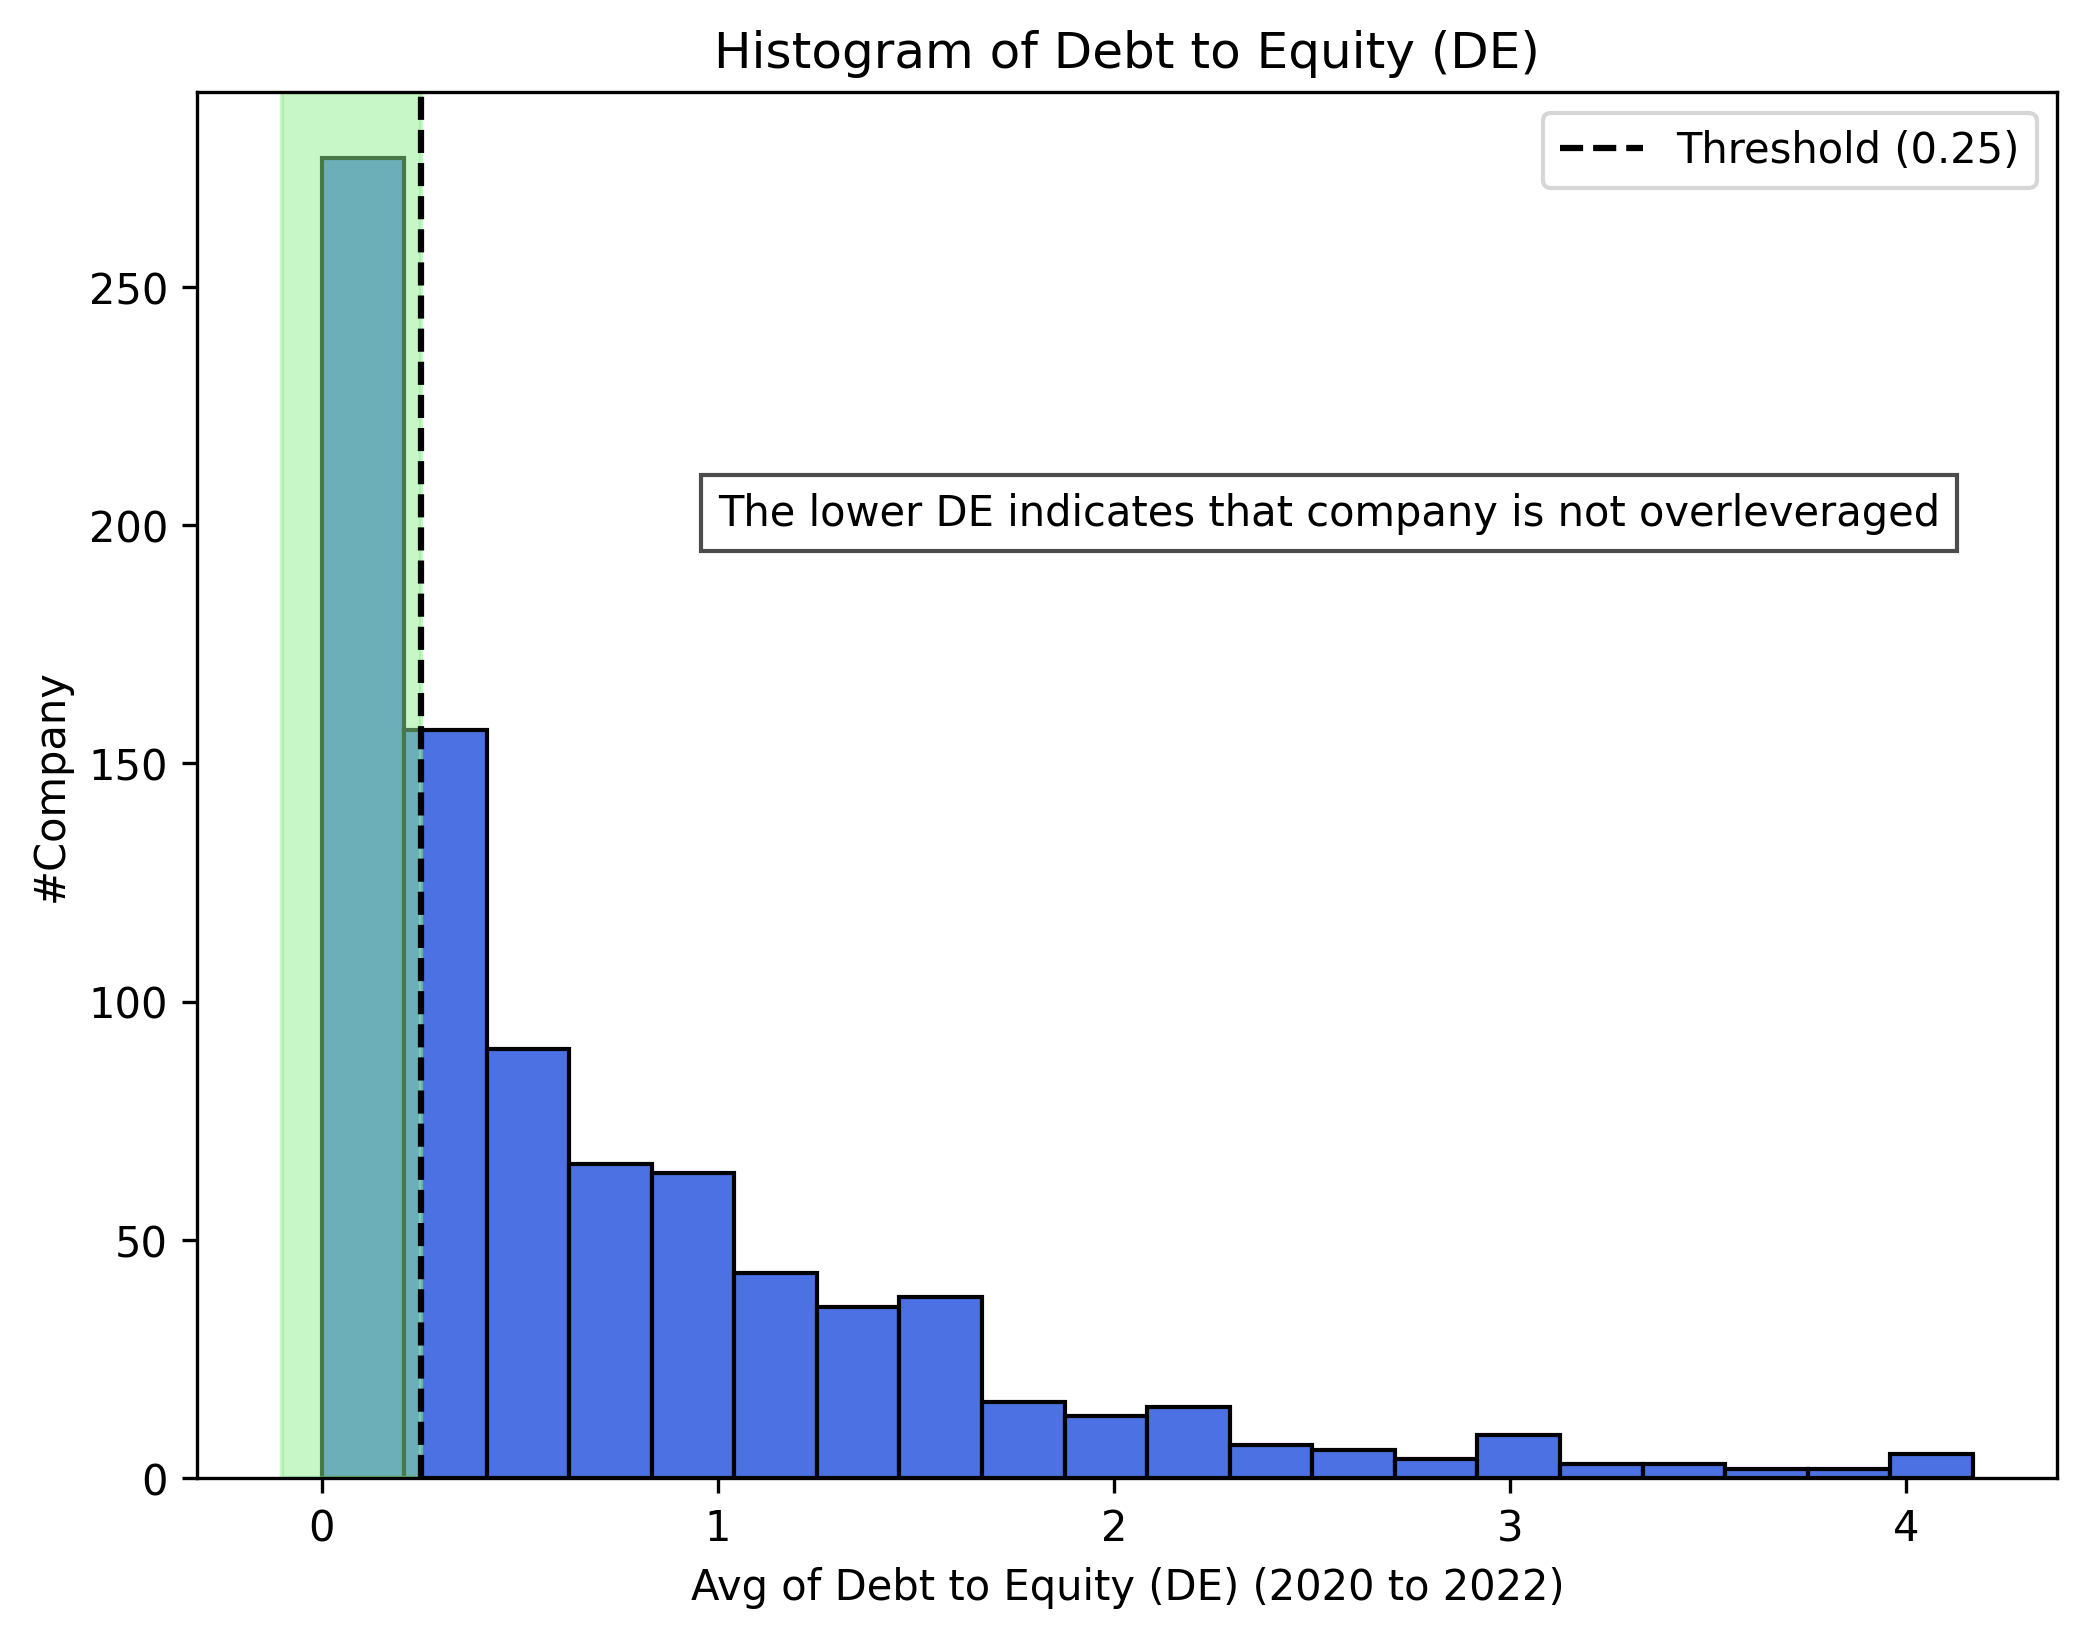

In [21]:
# Histogram for DE
plt.figure(figsize=(8, 6))
sns.histplot(df_debt_equity['DE'], bins=20, color='royalblue', alpha=0.95)
plt.title('Histogram of Debt to Equity (DE)')
plt.xlabel('Avg of Debt to Equity (DE) (2020 to 2022)')
plt.ylabel('#Company')

# Add a constant line at DE = 0.25
plt.axvline(x=0.25, color='black', linestyle='--', label='Threshold (0.25)')

# Extend background color for DE < 0.25
plt.axvspan(-0.1, 0.25, color='lightgreen', alpha=0.5)  # Extended range

# Format x-axis to show one decimal place
#plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

# Add a comment annotation
plt.annotate('The lower DE indicates that company is not overleveraged',
             xy=(2, 200),  # Adjust these coordinates as needed
             xytext=(1, 200),  # Position for the text label
             #arrowprops=dict(arrowstyle='->', color='black'),
             fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.7))

plt.legend()
plt.show()


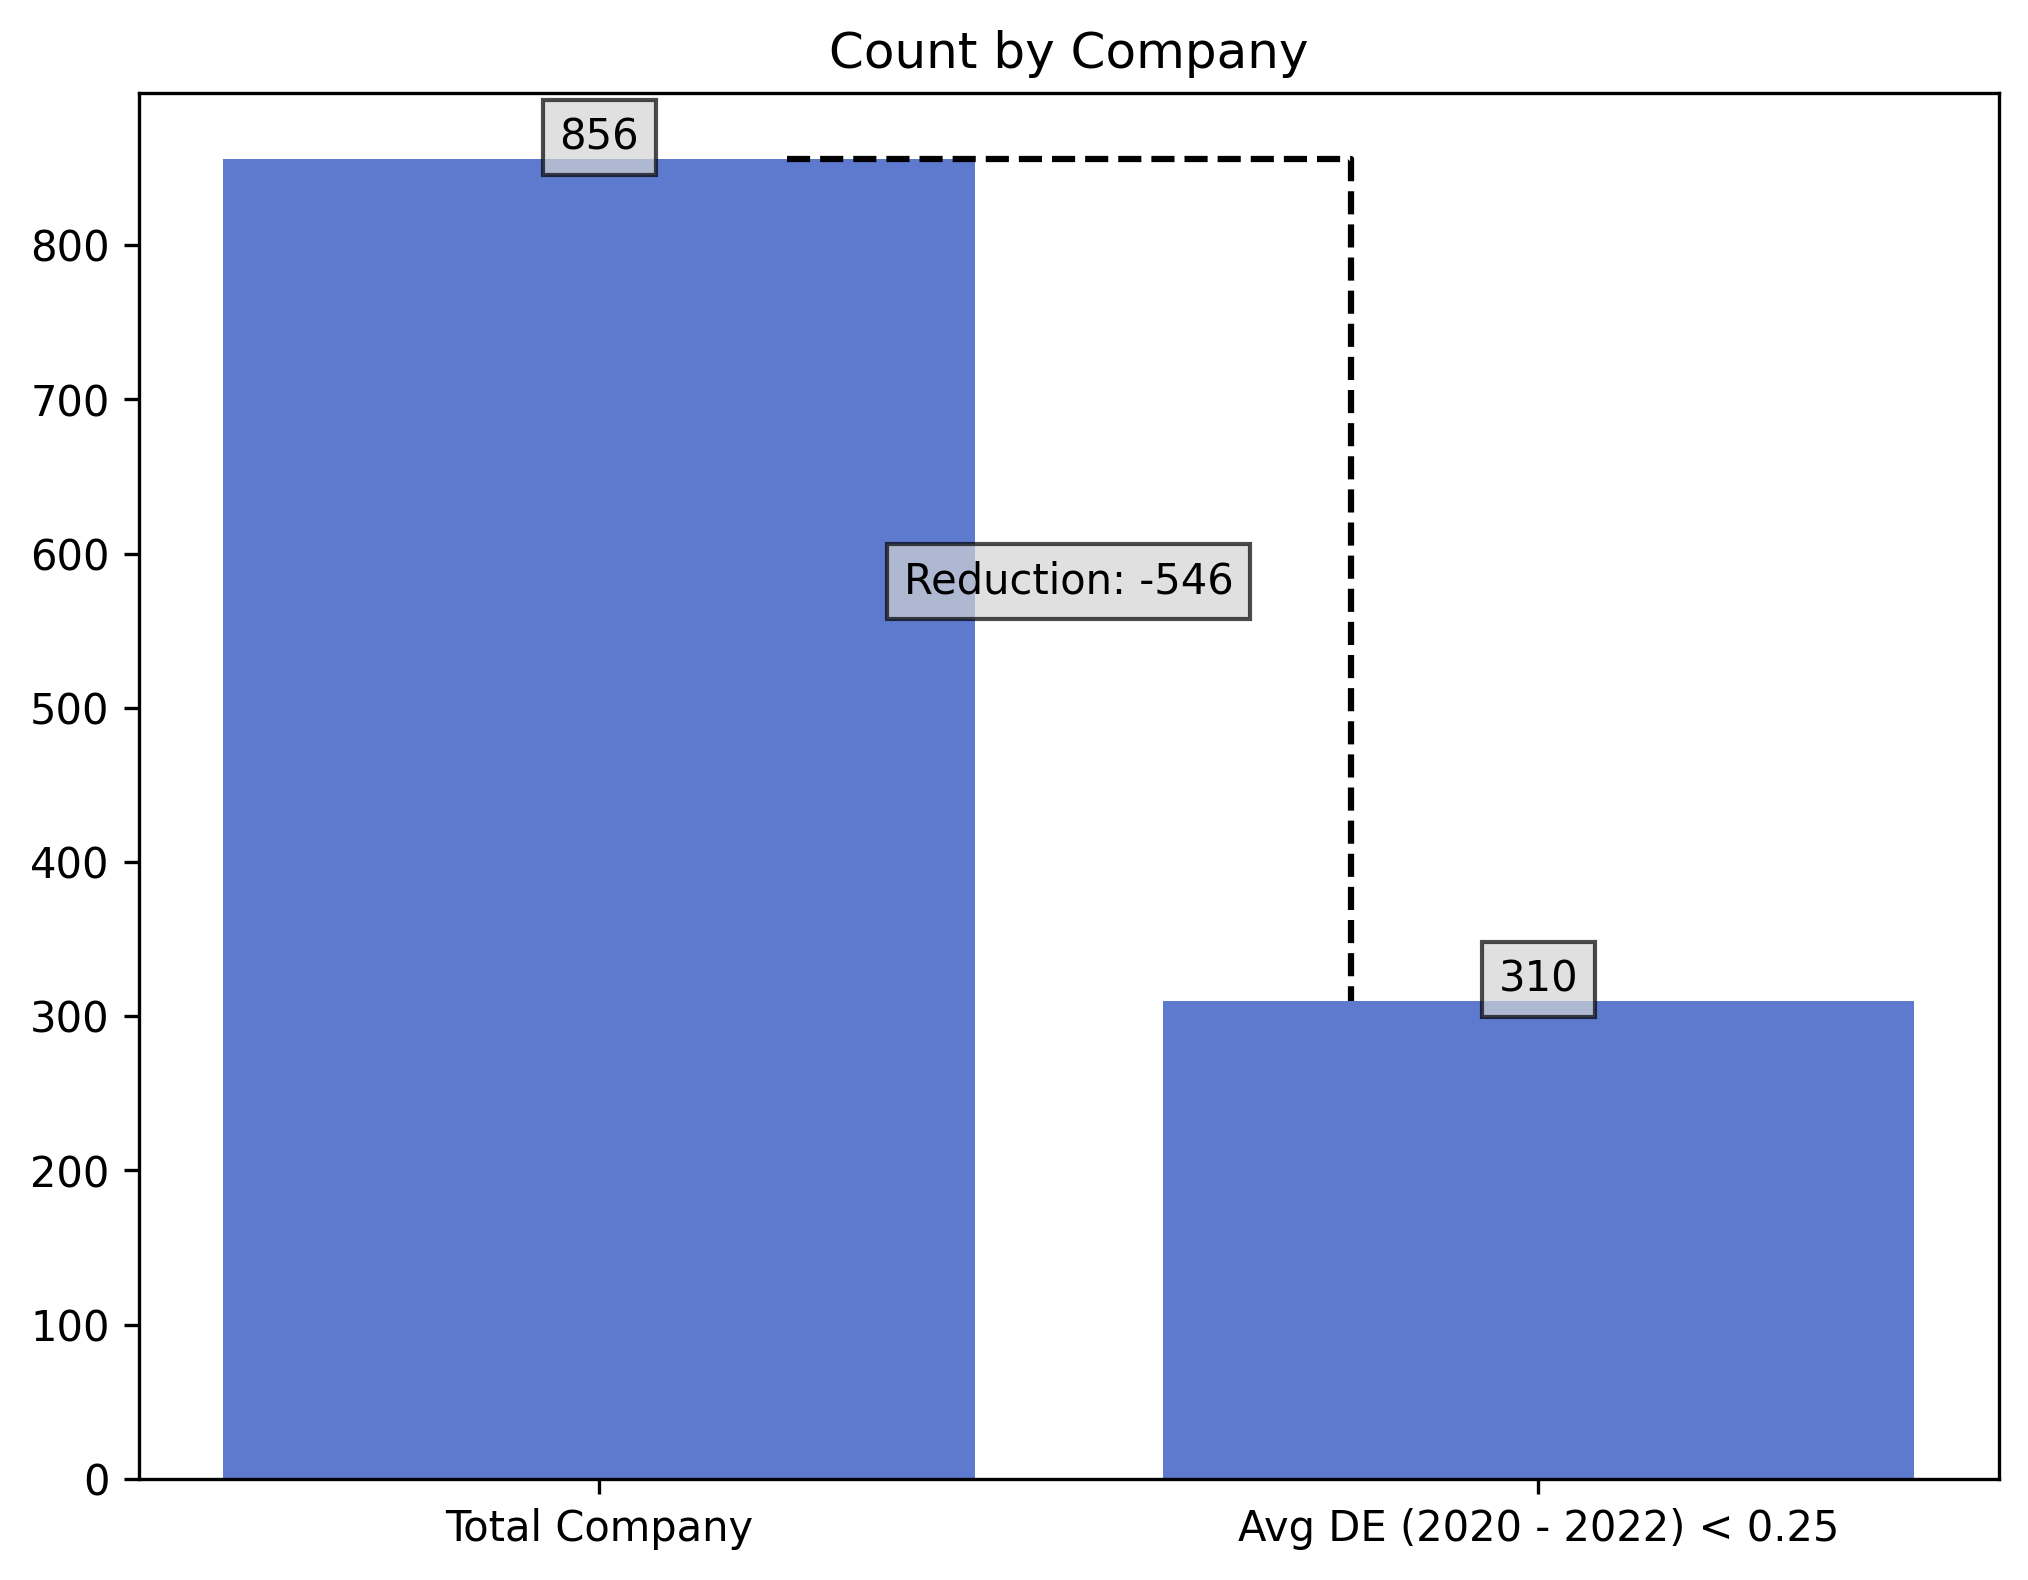

In [22]:
# Create a summary DataFrame for plotting DE_status
de_chart_counts = df_debt_equity['DE_status'].value_counts().reset_index()
de_chart_counts.columns = ['DE_status', 'count']

# Add a total count row
total_count = de_chart_counts['count'].sum()
total_row = pd.DataFrame({'DE_status': ['Total Company'], 'count': [total_count]})

# Combine all rows
de_chart_counts = pd.concat([total_row, de_chart_counts[de_chart_counts['DE_status'] == 'DE Lower than 0.25']])
de_chart_counts['DE_status'] = de_chart_counts['DE_status'].replace('DE Lower than 0.25', 'Avg DE (2020 - 2022) < 0.25')

# Bar plot for DE status
plt.figure(figsize=(8, 6))
sns.barplot(x="DE_status", y="count", data=de_chart_counts, color='royalblue', alpha = 0.95)

# Add data labels to bar plot
for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', bbox=dict(facecolor='lightgrey', alpha=0.7))

# Calculate reductions and annotate between bars
if len(de_chart_counts) > 1:
    # Reduction between Total and DE Lower than 0.25
    reduction_1 = de_chart_counts['count'].iloc[1] - de_chart_counts['count'].iloc[0]
    plt.annotate(f'Reduction: {reduction_1}',
                 xy=(0.5, (de_chart_counts['count'].iloc[0] + de_chart_counts['count'].iloc[1]) / 2 - 1),
                 ha='center', va='center', color='black',
                 bbox=dict(facecolor='lightgrey', alpha=0.7))

# Draw connectors
# Connector from Total to DE Lower than 0.25
x1 = [0.2, 0.8, 0.8]  # X positions for the connector
y1 = [de_chart_counts['count'].iloc[0], de_chart_counts['count'].iloc[0], de_chart_counts['count'].iloc[1]]  # Y positions
plt.plot(x1, y1, color='black', linestyle='--')

# Add labels and title to bar plot
plt.title('Count by Company')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [23]:
#Create table for monthly price
tickers = ["ZIGA.BK","ZEN.BK","ZAA.BK","YUASA.BK","YONG.BK","YGG.BK","XPG.BK","XO.BK","WPH.BK","WP.BK","WORK.BK","WINNER.BK","WINMED.BK","WINDOW.BK","WIN.BK","WIIK.BK","WICE.BK","WHAUP.BK","WHART.BK","WHAIR.BK","WHABT.BK","WHA.BK","WGE.BK","WFX.BK","WELL.BK","WAVE.BK","WARRIX.BK","WACOAL.BK","W.BK","VRANDA.BK","VPO.BK","VNG.BK","VL.BK","VIH.BK","VIBHA.BK","VGI.BK","VCOM.BK","VARO.BK","UVAN.BK","UV.BK","UTP.BK","UREKA.BK","UPOIC.BK","UPF.BK","UP.BK","UOBKH.BK","UNIQ.BK","UMS.BK","UMI.BK","UKEM.BK","UEC.BK","UBIS.BK","UBE.BK","UBA.BK","UAC.BK","TYCN.BK","TWZ.BK","TWPC.BK","TWP.BK","TVT.BK","TVO.BK","TVH.BK","TVDH.BK","TURTLE.BK","TU-PF.BK","TU.BK","TTW.BK","TTT.BK","TTLPF.BK","TTI.BK","TTCL.BK","TTB.BK","TTA.BK","TSTH.BK","TSTE.BK","TSI.BK","TSE.BK","TSC.BK","TRV.BK","TRUE.BK","TRUBB.BK","TRU.BK","TRT.BK","TRP.BK","TRITN.BK","TRC.BK","TR.BK","TQR.BK","TQM.BK","TPS.BK","TPRIME.BK","TPP.BK","TPOLY.BK","TPLAS.BK","TPL.BK","TPIPP.BK","TPIPL.BK","TPCS.BK","TPCH.BK","TPBI.BK","TPAC.BK","TPA.BK","TOPP.BK","TOP.BK","TOG.BK","TOA.BK","TNR.BK","TNPF.BK","TNPC.BK","TNP.BK","TNL.BK","TNITY.BK","TNH.BK","TNDT.BK","TMW.BK","TMT.BK","TMILL.BK","TMI.BK","TMD.BK","TMC.BK","TM.BK","TLI.BK","TLHPF.BK","TKT.BK","TKS.BK","TKN.BK","TKC.BK","TK.BK","TITLE.BK","TISCO.BK","TIPH.BK","TIPCO.BK","TIGER.BK","TIF1.BK","TIDLOR.BK","THREL.BK","THRE.BK","THMUI.BK","THIP.BK","THG.BK","THE.BK","THCOM.BK","THANI.BK","THANA.BK","THAI.BK","TH.BK","TGPRO.BK","TGH.BK","TGE.BK","TFMAMA.BK","TFM.BK","TFI.BK","TFG.BK","TERA.BK","TEKA.BK","TEGH.BK","TEAMG.BK","TEAM.BK","TCOAT.BK","TCMC.BK","TCJ.BK","TCC.BK","TCAP.BK","TC.BK","TBN.BK","TASCO.BK","TAPAC.BK","TAN.BK","TAKUNI.BK","TAE.BK","TACC.BK","SYNTEC.BK","SYNEX.BK","SYMC.BK","SWC.BK","SVT.BK","SVR.BK","SVOA.BK","SVI.BK","SUTHA.BK","SUSCO.BK","SUPER.BK","SUN.BK","SUC.BK","STX.BK","STPI.BK","STP.BK","STOWER.BK","STI.BK","STHAI.BK","STGT.BK","STECH.BK","STEC.BK","STC.BK","STANLY.BK","STA.BK","SSTRT.BK","SST.BK","SSSC.BK","SSPF.BK","SSP.BK","SSF.BK","SSC.BK","SRS.BK","SRIPANWA.BK","SRICHA.BK","SR.BK","SQ.BK","SPVI.BK","SPRIME.BK","SPREME.BK","SPRC.BK","SPI.BK","SPG.BK","SPCG.BK","SPC.BK","SPALI.BK","SPACK.BK","SPA.BK","SORKON.BK","SONIC.BK","SOLAR.BK","SO.BK","SNP.BK","SNNP.BK","SNC.BK","SMT.BK","SMPC.BK","SMK.BK","SMIT.BK","SMD.BK","SMART.BK","SM.BK","SLP.BK","SLM.BK","SKY.BK","SKR.BK","SKN.BK","SKE.BK","SK.BK","SJWD.BK","SITHAI.BK","SISB.BK","SIS.BK","SIRIP.BK","SIRI.BK","SINO.BK","SINGER.BK","SIMAT.BK","SICT.BK","SIAM.BK","SHR.BK","SHANG.BK","SGP.BK","SGF.BK","SGC.BK","SFT.BK","SFLEX.BK","SENX.BK","SENA.BK","SELIC.BK","SE-ED.BK","SECURE.BK","SEAOIL.BK","SEAFCO.BK","SE.BK","SDC.BK","SCP.BK","SCN.BK","SCM.BK","SCL.BK","SCI.BK","SCGP.BK","SCGD.BK","SCG.BK","SCCC.BK","SCC.BK","SCB.BK","SCAP.BK","SC.BK","SBNEXT.BK","SAWANG.BK","SAWAD.BK","SAV.BK","SAUCE.BK","SAT.BK","SAPPE.BK","SANKO.BK","SAMTEL.BK","SAMCO.BK","SAMART.BK","SAM.BK","SALEE.BK","SAK.BK","SAFE.BK","SAFARI.BK","SAF.BK","SABUY.BK","SABINA.BK","SAAM.BK","SA.BK","S11.BK","S&J.BK","S.BK","RWI.BK","RT.BK","RSP.BK","RS.BK","RPH.BK","RPC.BK","RP.BK","ROJNA.BK","ROH.BK","ROCTEC.BK","ROCK.BK","RML.BK","RJH.BK","RICHY.BK","READY.BK","RCL.BK","RBF.BK","RATCH.BK","RAM.BK","RABBIT.BK","QTCG.BK","QTC.BK","QLT.BK","QHPF.BK","QHOP.BK","QHHRREIT.BK","QH.BK","Q-CON.BK","PYLON.BK","PTTGC.BK","PTTEP.BK","PTT.BK","PTL.BK","PTG.BK","PTECH.BK","PTC.BK","PT.BK","PSTC.BK","PSP.BK","PSL.BK","PSH.BK","PSG.BK","PRTR.BK","PROUD.BK","PROSPECT.BK","PROS.BK","PROEN.BK","PRO.BK","PRM.BK","PRINC.BK","PRIN.BK","PRIME.BK","PRI.BK","PRG.BK","PRECHA.BK","PREB.BK","PRAPAT.BK","PRAKIT.BK","PR9.BK","PQS.BK","PPS.BK","PPPM.BK","PPP.BK","PPM.BK","PORT.BK","POPF.BK","POLY.BK","POLAR.BK","PMTA.BK","PMC.BK","PM.BK","PLUS.BK","PLT.BK","PLE.BK","PLAT.BK","PLANET.BK","PLANB.BK","PL.BK","PK.BK","PJW.BK","PIN.BK","PIMO.BK","PICO.BK","PHOL.BK","PHG.BK","PG.BK","PF.BK","PERM.BK","PEER.BK","PEACE.BK","PDJ.BK","PDG.BK","PCSGH.BK","PCE.BK","PCC.BK","PB.BK","PATO.BK","PAP.BK","PANEL.BK","PAF.BK","PACO.BK","OSP.BK","ORN.BK","ORI.BK","OR.BK","ONEE.BK","OHTL.BK","OGC.BK","OCC.BK","NYT.BK","NWR.BK","NVD.BK","NV.BK","NUSA.BK","NTV.BK","NTSC.BK","NSL.BK","NRF.BK","NPK.BK","NOVA.BK","NOK.BK","NOBLE.BK","NNCL.BK","NL.BK","NKI.BK","NFC.BK","NEX.BK","NEWS.BK","NEW.BK","NETBAY.BK","NER.BK","NEP.BK","NEO.BK","NDR.BK","NCP.BK","NCL.BK","NCH.BK","NCAP.BK","NC.BK","NATION.BK","NAT.BK","NAM.BK","MVP.BK","MUD.BK","MTW.BK","MTI.BK","MTC.BK","M-STOR.BK","MST.BK","MSC.BK","M-PAT.BK","MOSHI.BK","MORE.BK","MOONG.BK","MONO.BK","MODERN.BK","MNRF.BK","MNIT2.BK","MNIT.BK","ML.BK","MK.BK","MJLF.BK","MJD.BK","MITSIB.BK","MIT.BK","MIPF.BK","MINT.BK","MILL.BK","M-II.BK","MIDA.BK","MICRO.BK","MGT.BK","MGI.BK","MGC.BK","MFEC.BK","MFC.BK","METCO.BK","META.BK","MENA.BK","MEGA.BK","MEB.BK","MDX.BK","MCS.BK","MCOT.BK","M-CHAI.BK","MCA.BK","MC.BK","MBK.BK","MBAX.BK","MATI.BK","MATCH.BK","MASTER.BK","MANRIN.BK","MALEE.BK","MAJOR.BK","MAGURO.BK","M.BK","LUXF.BK","LTS.BK","LST.BK","LRH.BK","LPN.BK","LPH.BK","LPF.BK","LOXLEY.BK","LIT.BK","LHSC.BK","LHPF.BK","LHK.BK","LHHOTEL.BK","LHFG.BK","LH.BK","LEO.BK","LEE.BK","LDC.BK","LANNA.BK","LALIN.BK","L&E.BK","KYE.BK","KWM.BK","KWI.BK","KWC.BK","KUN.BK","KUMWEL.BK","KTMS.BK","KTIS.BK","KTC.BK","KTBSTMR.BK","KTB.BK","KSL.BK","KPNPF.BK","KOOL.BK","KLINIQ.BK","KKP.BK","KKC.BK","KK.BK","KJL.BK","KISS.BK","KIAT.BK","KGI.BK","KGEN.BK","KEX.BK","KDH.BK","KCM.BK","KCG.BK","KCE.BK","KCC.BK","KCAR.BK","KC.BK","KBS.BK","KBANK.BK","KASET.BK","KAMART.BK","K.BK","JUBILE.BK","JTS.BK","JSP.BK","JR.BK","JPARK.BK","JMT.BK","JMART.BK","JKN.BK","JDF.BK","JCT.BK","JCKH.BK","JCK.BK","JAS.BK","JAK.BK","J.BK","IVL.BK","ITTHI.BK","ITNS.BK","ITEL.BK","ITD.BK","ITC.BK","IT.BK","IRPC.BK","IRCP.BK","IRC.BK","IP.BK","INTUCH.BK","INSURE.BK","INSET.BK","INOX.BK","INGRS.BK","INETREIT.BK","INET.BK","IND.BK","IMPACT.BK","IMH.BK","ILM.BK","ILINK.BK","III.BK","IIG.BK","IHL.BK","IFS.BK","ICN.BK","ICHI.BK","ICC.BK","I2.BK","HYDROGEN.BK","HYDRO.BK","HUMAN.BK","HTECH.BK","HTC.BK","HPT.BK","HPF.BK","HMPRO.BK","HL.BK","HFT.BK","HENG.BK","HEALTH.BK","HARN.BK","HANA.BK","GYT.BK","GVREIT.BK","GUNKUL.BK","GULF.BK","GTV.BK","GTB.BK","GSTEEL.BK","GSC.BK","GROREIT.BK","GREEN.BK","GRAND.BK","GRAMMY.BK","GPSC.BK","GPI.BK","GLORY.BK","GLOCON.BK","GLOBAL.BK","GLAND.BK","GL.BK","GJS.BK","GIFT.BK","GGC.BK","GFPT.BK","GFC.BK","GENCO.BK","GEL.BK","GCAP.BK","GC.BK","GBX.BK","GAHREIT.BK","GABLE.BK","FVC.BK","FUTUREPF.BK","FTREIT.BK","FTI.BK","FTE.BK","FSX.BK","FSMART.BK","FPT.BK","FPI.BK","FORTH.BK","FNS.BK","FN.BK","FMT.BK","FM.BK","FLOYD.BK","FE.BK","FANCY.BK","F&D.BK","EVER.BK","EURO.BK","ETL.BK","ETE.BK","ETC.BK","ESTAR.BK","ERW.BK","EPG.BK","EP.BK","EMC.BK","EKH.BK","EGCO.BK","EFORL.BK","EE.BK","ECL.BK","ECF.BK","EASTW.BK","EASON.BK","EA.BK","DV8.BK","DUSIT.BK","DTCI.BK","DTCENT.BK","DRT.BK","DREIT.BK","DPAINT.BK","DOHOME.BK","DOD.BK","DMT.BK","DITTO.BK","DIMET.BK","DHOUSE.BK","DEXON.BK","DEMCO.BK","DELTA.BK","DDD.BK","DCON.BK","DCC.BK","D.BK","CWT.BK","CV.BK","CTW.BK","CTARAF.BK","CSS.BK","CSR.BK","CSP.BK","CSC.BK","CREDIT.BK","CRD.BK","CRC.BK","CRANE.BK","CPW.BK","CPTGF.BK","CPT.BK","CPR.BK","CPNREIT.BK","CPNCG.BK","CPN.BK","CPL.BK","CPI.BK","CPH.BK","CPF.BK","CPAXT.BK","CPANEL.BK","CPALL.BK","COMAN.BK","COM7.BK","COLOR.BK","COCOCO.BK","CNT.BK","CMR.BK","CMO.BK","CMC.BK","CMAN.BK","CM.BK","CKP.BK","CK.BK","CIVIL.BK","CITY.BK","CIMBT.BK","CIG.BK","CI.BK","CHOW.BK","CHOTI.BK","CHO.BK","CHIC.BK","CHG.BK","CHEWA.BK","CHAYO.BK","CHASE.BK","CHARAN.BK","CHAO.BK","CH.BK","CGH.BK","CGD.BK","CFRESH.BK","CFARM.BK","CEYE.BK","CENTEL.BK","CEN.BK","CCP.BK","CCET.BK","CBG.BK","CAZ.BK","BYD.BK","B-WORK.BK","BWG.BK","BVG.BK","BUI.BK","BTW.BK","BTS.BK","BTNC.BK","BTG.BK","BTC.BK","BSRC.BK","BSM.BK","BSBM.BK","BRR.BK","BROCK.BK","BRI.BK","BR.BK","BPS.BK","BPP.BK","BOL.BK","BOFFICE.BK","BM.BK","BLISS.BK","BLESS.BK","BLC.BK","BLAND.BK","BLA.BK","BKKCP.BK","BKIH.BK","BKGI.BK","BKD.BK","BJCHI.BK","BJC.BK","BIZ.BK","BIS.BK","BIOTEC.BK","BIG.BK","BH.BK","BGT.BK","BGRIM.BK","BGC.BK","BEYOND.BK","BEM.BK","BEC.BK","BEAUTY.BK","BE8.BK","BDMS.BK","BCT.BK","BCPG.BK","BCP.BK","BCH.BK","BC.BK","BBL.BK","BBIK.BK","BBGI.BK","BAY.BK","BAREIT.BK","BANPU.BK","BAM.BK","BAFS.BK","BA.BK","B52.BK","B.BK","AYUD.BK","AWC.BK","AURA.BK","AUCT.BK","AU.BK","ATP30.BK","ASW.BK","ASP.BK","ASN.BK","ASK.BK","ASIMAR.BK","ASIAN.BK","ASIA.BK","ASEFA.BK","ASAP.BK","AS.BK","ARROW.BK","ARIP.BK","ARIN.BK","AQUA.BK","APURE.BK","APP.BK","APO.BK","APEX.BK","APCS.BK","APCO.BK","AP.BK","AOT.BK","ANI.BK","ANAN.BK","AMR.BK","AMC.BK","AMATAV.BK","AMATAR.BK","AMATA.BK","AMARIN.BK","AMARC.BK","AMANAH.BK","AMA.BK","ALUCON.BK","ALT.BK","ALPHAX.BK","ALLY.BK","ALLA.BK","AKS.BK","AKR.BK","AKP.BK","AJA.BK","AJ.BK","AIT.BK","AIRA.BK","AIMIRT.BK","AIMCG.BK","AIE.BK","AI.BK","AHC.BK","AH.BK","AGE.BK","AFC.BK","AF.BK","AEONTS.BK","AE.BK","ADVICE.BK","ADVANC.BK","ADD.BK","ADB.BK","ACG.BK","ACE.BK","ACC.BK","ACAP.BK","ABM.BK","AAV.BK","AAI.BK","A5.BK","A.BK","3K-BAT.BK","2S.BK","24CS.BK"]  # Add more tickers as needed

# Empty list to store data
all_stock_data = []

# Empty list to store DataFrames
all_stock_data = []

# Loop through each ticker and get stock prices
for ticker in tickers:
    # Get the stock data as DataFrame or Series
    monthly_prices = get_monthly_stock_prices(ticker,start_date="2019-01-01", end_date="2023-12-31")
    # Append the stock data (not the ticker string) to the list
    all_stock_data.append(monthly_prices)

# Combine all data into a single DataFrame
combined_data = pd.concat(all_stock_data)


ERROR:yfinance:$TERA.BK: possibly delisted; no price data found  (1mo 2019-01-01 -> 2023-12-31) (Yahoo error = "Data doesn't exist for startDate = 1546275600, endDate = 1703955600")
ERROR:yfinance:$STX.BK: possibly delisted; no price data found  (1mo 2019-01-01 -> 2023-12-31) (Yahoo error = "Data doesn't exist for startDate = 1546275600, endDate = 1703955600")
ERROR:yfinance:$SPREME.BK: possibly delisted; no price data found  (1mo 2019-01-01 -> 2023-12-31) (Yahoo error = "Data doesn't exist for startDate = 1546275600, endDate = 1703955600")
ERROR:yfinance:$SCGD.BK: possibly delisted; no price data found  (1mo 2019-01-01 -> 2023-12-31)
ERROR:yfinance:$QTCG.BK: possibly delisted; no price data found  (1mo 2019-01-01 -> 2023-12-31) (Yahoo error = "Data doesn't exist for startDate = 1546275600, endDate = 1703955600")
ERROR:yfinance:$PMC.BK: possibly delisted; no price data found  (1mo 2019-01-01 -> 2023-12-31) (Yahoo error = "Data doesn't exist for startDate = 1546275600, endDate = 1703955

In [24]:
#CALCULATION: Get stock price in 2022
monthly_prices = combined_data.copy()
#Make 'Date' as header
monthly_prices = monthly_prices.reset_index()
#filter only last month in 2022
monthly_prices = monthly_prices[monthly_prices['Date'].dt.year == 2022]
monthly_prices = monthly_prices[monthly_prices['Date'].dt.month == 12]
monthly_prices

,Date,Close,symbol
47,2022-12-01,3.400000,ZIGA
105,2022-12-01,16.547201,ZEN
168,2022-12-01,12.476295,YUASA
184,2022-12-01,1.929306,YONG
231,2022-12-01,8.766486,YGG
...,...,...,...
45635,2022-12-01,3.882733,A5
45695,2022-12-01,4.980000,A
45733,2022-12-01,62.384308,3K-BAT
45793,2022-12-01,2.597723,2S


In [25]:
# FCF (target 8%) 2022

#CALCULATION: Get "Basic Average Shares" in 2022 only
avg_share = maindf[maindf['data'] == 'Basic Average Shares']
avg_share = avg_share[avg_share['year'] == '2022-12-31']
avg_share = avg_share.drop(['type', 'data', 'year'], axis = 1)
avg_share = avg_share.groupby('symbol')['THB'].mean().reset_index()
avg_share = avg_share.rename(columns={'THB': 'avg_share'})

#CALCULATION: Get market cap from 2022 last month price * Basic Average Shares
#merge avg_share with monthly_prices
mcap = pd.merge(monthly_prices, avg_share, on='symbol', how='inner')
#create new column market_cap using Close * avg_share
mcap['market_cap'] = mcap['Close'] * mcap['avg_share']
mcap

#CALCULATION: Get "Free Cash Flow" in 2022 only
free_cash = maindf[maindf['data'] == 'Free Cash Flow']
free_cash = free_cash[free_cash['year'] == '2022-12-31']
free_cash = free_cash.drop(['type', 'data', 'year'], axis = 1)
free_cash = free_cash.rename(columns={'THB': 'free_cash_flow'})

#CALCULATION: Get FCF by using Free Cash Flow / Market cap
#merge free_cash with mcap
fcf = pd.merge(mcap, free_cash, on='symbol', how='inner')
#create new column called FCF using free_cash_flow / market_cap
fcf['FCF'] = fcf['free_cash_flow'] / fcf['market_cap']
#remove outlier in 'FCF' using sigma
fcf = fcf[np.abs(fcf['FCF'] - fcf['FCF'].mean()) / fcf['FCF'].std() < 3]
fcf['FCF_status'] = fcf['FCF'].apply(lambda x: 'Lower than 0.08' if x < 0.08 else 'More than 0.08')
fcf = fcf.sort_values(by='FCF', ascending=False)
fcf

fcf_chart = fcf[['symbol', 'FCF_status']]
#add DE_status from previous table
fcf_chart = pd.merge(fcf_chart, df_debt_equity[['symbol', 'DE_status']], on='symbol', how='inner')
#filter DE_status only DE lower than 0.25
fcf_chart = fcf_chart[fcf_chart['DE_status'] == 'DE Lower than 0.25']
fcf_chart = fcf_chart.drop_duplicates()
#drop DE_status and symbol
fcf_chart = fcf_chart.drop(['DE_status'], axis=1)

# # Histogram for FCF
# plt.figure(figsize=(8, 6))
# sns.histplot(fcf['FCF'], bins=20, color='royalblue', alpha = 0.95)
# plt.title('Histogram of FCF')
# plt.xlabel('FCF')
# plt.ylabel('Frequency')

# # Add a constant line at FCF = 0.08
# plt.axvline(x=0.08, color='black', linestyle='--', label='Threshold (0.08)')
# plt.legend()
# plt.show()

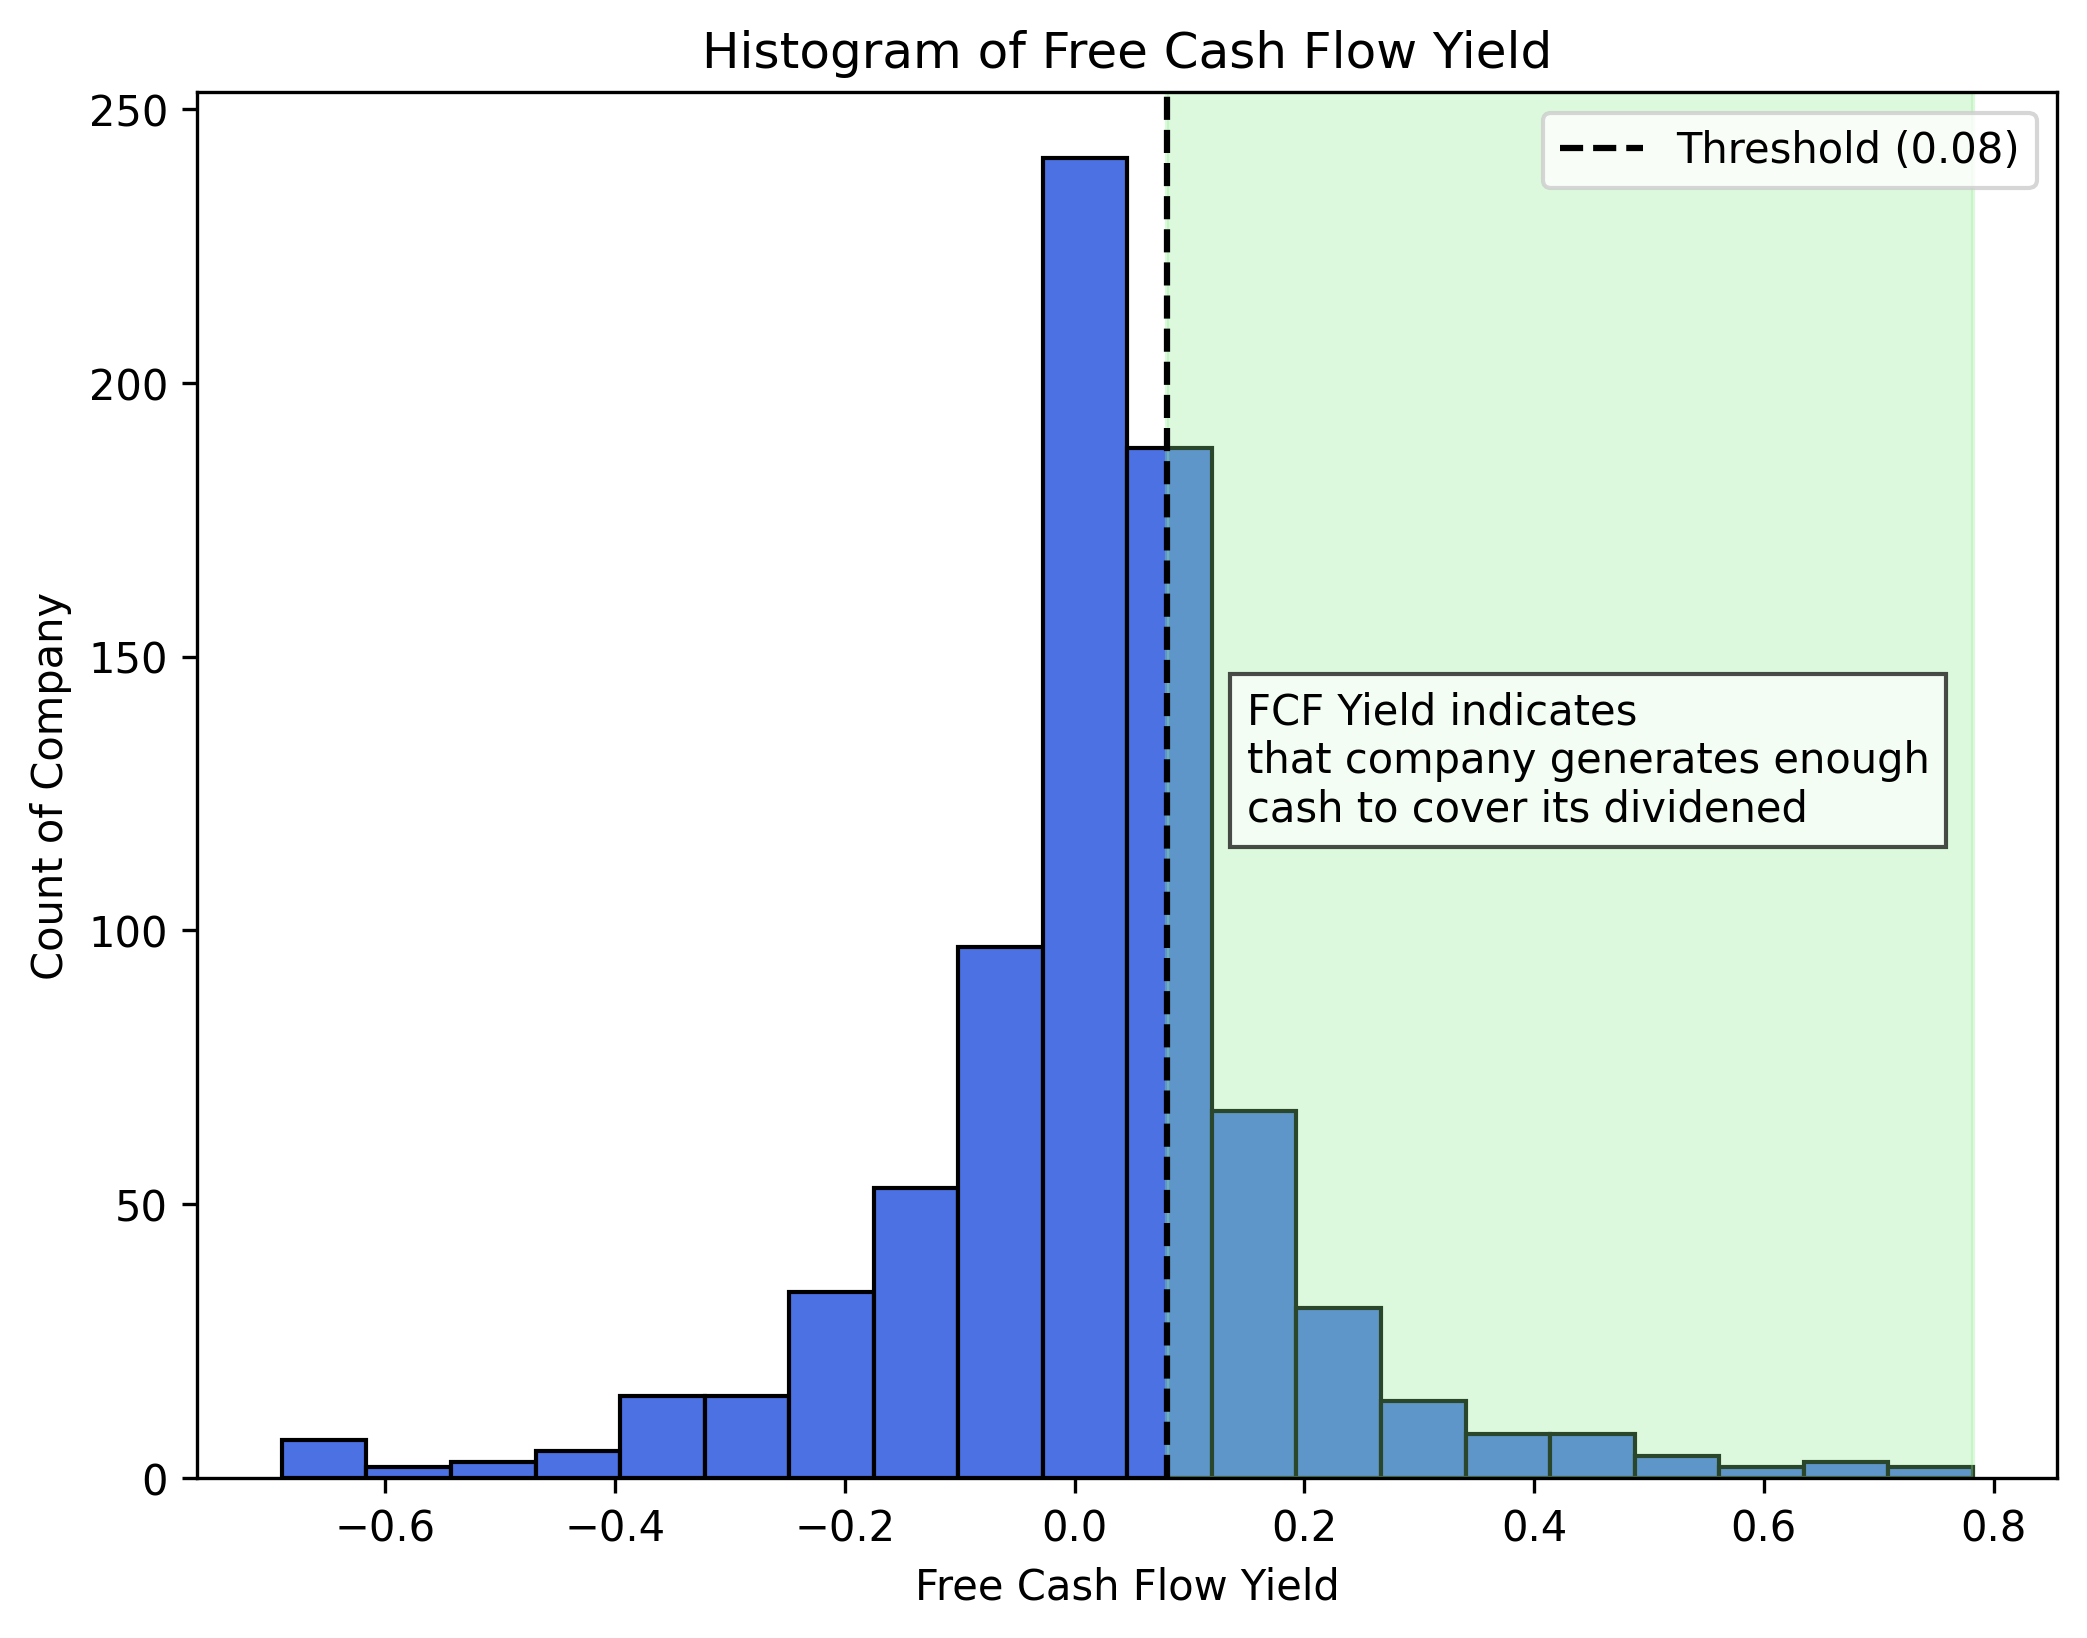

In [26]:
# Histogram for FCF
plt.figure(figsize=(8, 6))
sns.histplot(fcf['FCF'], bins=20, color='royalblue', alpha=0.95)
plt.title('Histogram of Free Cash Flow Yield')
plt.xlabel('Free Cash Flow Yield')
plt.ylabel('Count of Company')

# Add a constant line at FCF = 0.08
plt.axvline(x=0.08, color='black', linestyle='--', label='Threshold (0.08)')

# Extend background color for FCF > 0.08
plt.axvspan(0.08, fcf['FCF'].max(), color='lightgreen', alpha=0.3)

# Add a multi-line comment annotation
plt.annotate('FCF Yield indicates\nthat company generates enough\ncash to cover its dividened',
             xy=(0.1, 5),  # Adjust these coordinates as needed
             xytext=(0.15, 120),  # Position for the text label
             #arrowprops=dict(arrowstyle='->', color='black'),
             fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.7))

plt.legend(loc='upper right', bbox_to_anchor=(1, 1), framealpha=0.8)
plt.show()


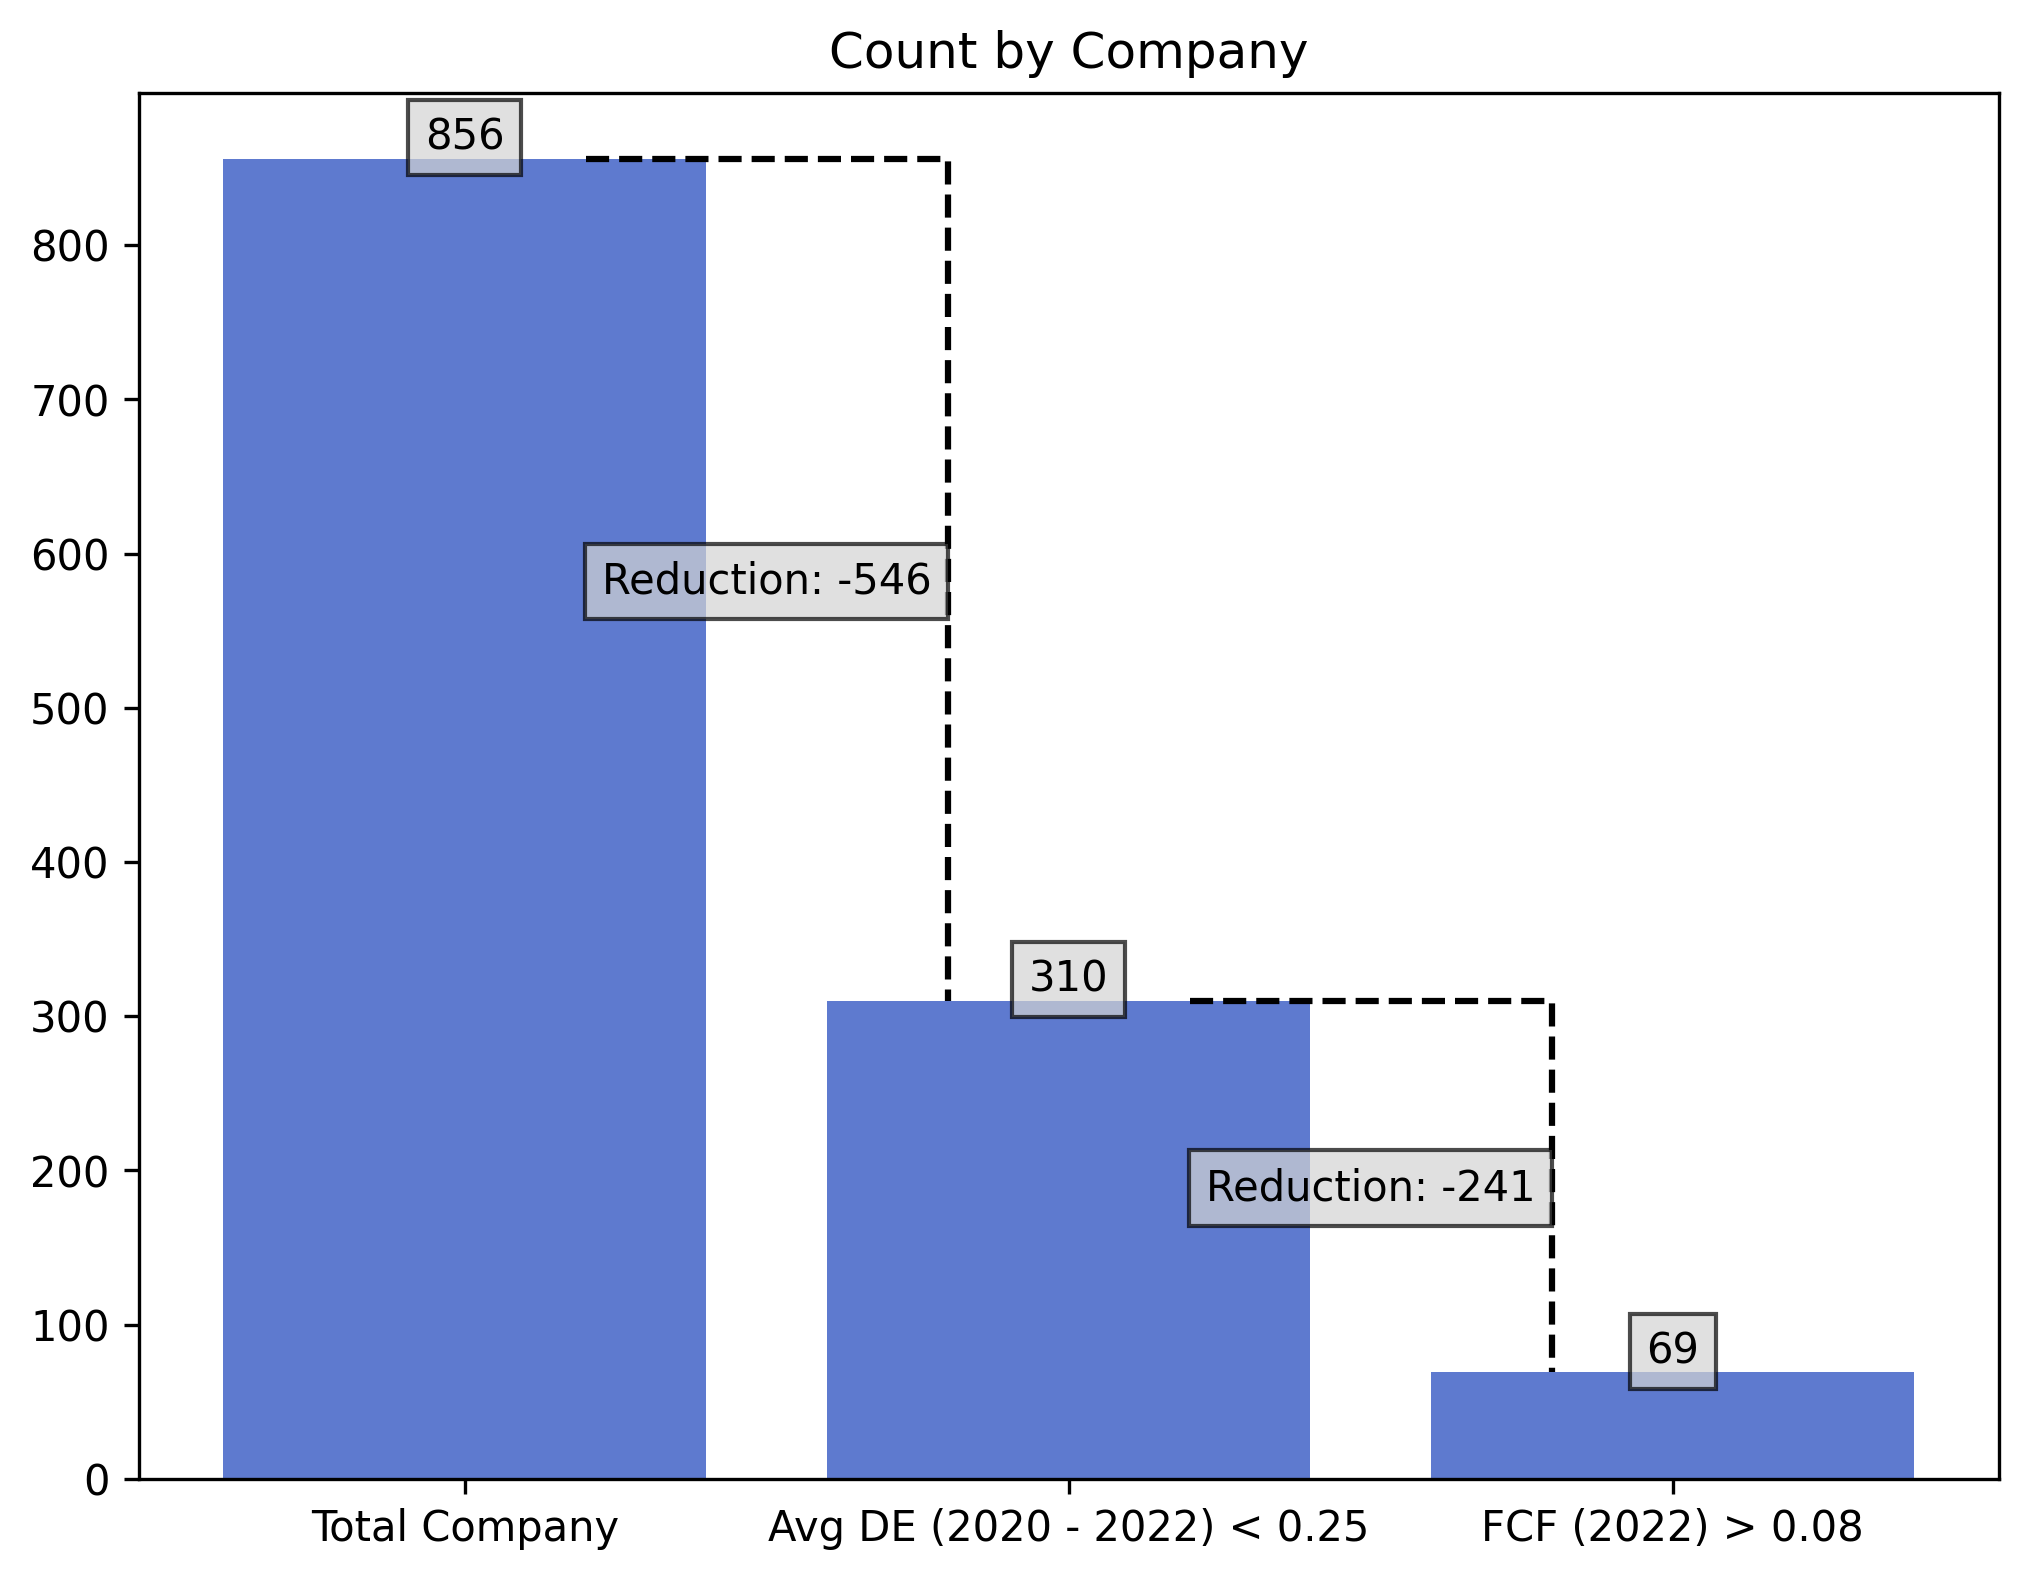

In [27]:
# Create a summary DataFrame for plotting DE_status
de_chart_counts = df_debt_equity['DE_status'].value_counts().reset_index()
de_chart_counts.columns = ['DE_status', 'count']

# Add a total count row
total_count = de_chart_counts['count'].sum()
total_row = pd.DataFrame({'DE_status': ['Total Company'], 'count': [total_count]})

# Count for FCF > 0.08
fcf_count = fcf_chart[fcf_chart['FCF_status'] == 'More than 0.08'].shape[0]
fcf_row = pd.DataFrame({'DE_status': ['FCF More than 0.08'], 'count': [fcf_count]})
fcf_row['DE_status'] = fcf_row['DE_status'].replace('FCF More than 0.08', 'FCF (2022) > 0.08')

# Combine all rows
de_chart_counts = pd.concat([total_row, de_chart_counts[de_chart_counts['DE_status'] == 'DE Lower than 0.25'], fcf_row])
de_chart_counts['DE_status'] = de_chart_counts['DE_status'].replace('DE Lower than 0.25', 'Avg DE (2020 - 2022) < 0.25')

# Bar plot for DE status
plt.figure(figsize=(8, 6))
sns.barplot(x="DE_status", y="count", data=de_chart_counts, color='royalblue', alpha = 0.95)

# Add data labels to bar plot
for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', bbox=dict(facecolor='lightgrey', alpha=0.7))

# Calculate reductions and annotate between bars
if len(de_chart_counts) > 2:
    # Reduction between Total and DE Lower than 0.25
    reduction_1 = de_chart_counts['count'].iloc[1] - de_chart_counts['count'].iloc[0]
    plt.annotate(f'Reduction: {reduction_1}',
                 xy=(0.5, (de_chart_counts['count'].iloc[0] + de_chart_counts['count'].iloc[1]) / 2 - 1),
                 ha='center', va='center', color='black',
                 bbox=dict(facecolor='lightgrey', alpha=0.7))

    # Reduction between DE Lower than 0.25 and FCF More than 0.08
    reduction_2 = de_chart_counts['count'].iloc[2] - de_chart_counts['count'].iloc[1]
    plt.annotate(f'Reduction: {reduction_2}',
                 xy=(1.5, (de_chart_counts['count'].iloc[1] + de_chart_counts['count'].iloc[2]) / 2 - 1),
                 ha='center', va='center', color='black',
                 bbox=dict(facecolor='lightgrey', alpha=0.7))

# Draw connectors
# Connector from Total to DE Lower than 0.25
x1 = [0.2, 0.8, 0.8]  # X positions for the connector
y1 = [de_chart_counts['count'].iloc[0], de_chart_counts['count'].iloc[0], de_chart_counts['count'].iloc[1]]  # Y positions
plt.plot(x1, y1, color='black', linestyle='--')

# Connector from DE Lower than 0.25 to FCF More than 0.08
x2 = [1.2, 1.8, 1.8]  # X positions for the connector (horizontal to the center of the 3rd bar)
y2 = [de_chart_counts['count'].iloc[1], de_chart_counts['count'].iloc[1], de_chart_counts['count'].iloc[2]]  # Y positions
plt.plot(x2, y2, color='black', linestyle='--')

# Add labels and title to bar plot
plt.title('Count by Company')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [28]:
#Create Dividend Yield Table
tickers = ["ZIGA.BK","ZEN.BK","ZAA.BK","YUASA.BK","YONG.BK","YGG.BK","XPG.BK","XO.BK","WPH.BK","WP.BK","WORK.BK","WINNER.BK","WINMED.BK","WINDOW.BK","WIN.BK","WIIK.BK","WICE.BK","WHAUP.BK","WHART.BK","WHAIR.BK","WHABT.BK","WHA.BK","WGE.BK","WFX.BK","WELL.BK","WAVE.BK","WARRIX.BK","WACOAL.BK","W.BK","VRANDA.BK","VPO.BK","VNG.BK","VL.BK","VIH.BK","VIBHA.BK","VGI.BK","VCOM.BK","VARO.BK","UVAN.BK","UV.BK","UTP.BK","UREKA.BK","UPOIC.BK","UPF.BK","UP.BK","UOBKH.BK","UNIQ.BK","UMS.BK","UMI.BK","UKEM.BK","UEC.BK","UBIS.BK","UBE.BK","UBA.BK","UAC.BK","TYCN.BK","TWZ.BK","TWPC.BK","TWP.BK","TVT.BK","TVO.BK","TVH.BK","TVDH.BK","TURTLE.BK","TU-PF.BK","TU.BK","TTW.BK","TTT.BK","TTLPF.BK","TTI.BK","TTCL.BK","TTB.BK","TTA.BK","TSTH.BK","TSTE.BK","TSI.BK","TSE.BK","TSC.BK","TRV.BK","TRUE.BK","TRUBB.BK","TRU.BK","TRT.BK","TRP.BK","TRITN.BK","TRC.BK","TR.BK","TQR.BK","TQM.BK","TPS.BK","TPRIME.BK","TPP.BK","TPOLY.BK","TPLAS.BK","TPL.BK","TPIPP.BK","TPIPL.BK","TPCS.BK","TPCH.BK","TPBI.BK","TPAC.BK","TPA.BK","TOPP.BK","TOP.BK","TOG.BK","TOA.BK","TNR.BK","TNPF.BK","TNPC.BK","TNP.BK","TNL.BK","TNITY.BK","TNH.BK","TNDT.BK","TMW.BK","TMT.BK","TMILL.BK","TMI.BK","TMD.BK","TMC.BK","TM.BK","TLI.BK","TLHPF.BK","TKT.BK","TKS.BK","TKN.BK","TKC.BK","TK.BK","TITLE.BK","TISCO.BK","TIPH.BK","TIPCO.BK","TIGER.BK","TIF1.BK","TIDLOR.BK","THREL.BK","THRE.BK","THMUI.BK","THIP.BK","THG.BK","THE.BK","THCOM.BK","THANI.BK","THANA.BK","THAI.BK","TH.BK","TGPRO.BK","TGH.BK","TGE.BK","TFMAMA.BK","TFM.BK","TFI.BK","TFG.BK","TERA.BK","TEKA.BK","TEGH.BK","TEAMG.BK","TEAM.BK","TCOAT.BK","TCMC.BK","TCJ.BK","TCC.BK","TCAP.BK","TC.BK","TBN.BK","TASCO.BK","TAPAC.BK","TAN.BK","TAKUNI.BK","TAE.BK","TACC.BK","SYNTEC.BK","SYNEX.BK","SYMC.BK","SWC.BK","SVT.BK","SVR.BK","SVOA.BK","SVI.BK","SUTHA.BK","SUSCO.BK","SUPER.BK","SUN.BK","SUC.BK","STX.BK","STPI.BK","STP.BK","STOWER.BK","STI.BK","STHAI.BK","STGT.BK","STECH.BK","STEC.BK","STC.BK","STANLY.BK","STA.BK","SSTRT.BK","SST.BK","SSSC.BK","SSPF.BK","SSP.BK","SSF.BK","SSC.BK","SRS.BK","SRIPANWA.BK","SRICHA.BK","SR.BK","SQ.BK","SPVI.BK","SPRIME.BK","SPREME.BK","SPRC.BK","SPI.BK","SPG.BK","SPCG.BK","SPC.BK","SPALI.BK","SPACK.BK","SPA.BK","SORKON.BK","SONIC.BK","SOLAR.BK","SO.BK","SNP.BK","SNNP.BK","SNC.BK","SMT.BK","SMPC.BK","SMK.BK","SMIT.BK","SMD.BK","SMART.BK","SM.BK","SLP.BK","SLM.BK","SKY.BK","SKR.BK","SKN.BK","SKE.BK","SK.BK","SJWD.BK","SITHAI.BK","SISB.BK","SIS.BK","SIRIP.BK","SIRI.BK","SINO.BK","SINGER.BK","SIMAT.BK","SICT.BK","SIAM.BK","SHR.BK","SHANG.BK","SGP.BK","SGF.BK","SGC.BK","SFT.BK","SFLEX.BK","SENX.BK","SENA.BK","SELIC.BK","SE-ED.BK","SECURE.BK","SEAOIL.BK","SEAFCO.BK","SE.BK","SDC.BK","SCP.BK","SCN.BK","SCM.BK","SCL.BK","SCI.BK","SCGP.BK","SCGD.BK","SCG.BK","SCCC.BK","SCC.BK","SCB.BK","SCAP.BK","SC.BK","SBNEXT.BK","SAWANG.BK","SAWAD.BK","SAV.BK","SAUCE.BK","SAT.BK","SAPPE.BK","SANKO.BK","SAMTEL.BK","SAMCO.BK","SAMART.BK","SAM.BK","SALEE.BK","SAK.BK","SAFE.BK","SAFARI.BK","SAF.BK","SABUY.BK","SABINA.BK","SAAM.BK","SA.BK","S11.BK","S&J.BK","S.BK","RWI.BK","RT.BK","RSP.BK","RS.BK","RPH.BK","RPC.BK","RP.BK","ROJNA.BK","ROH.BK","ROCTEC.BK","ROCK.BK","RML.BK","RJH.BK","RICHY.BK","READY.BK","RCL.BK","RBF.BK","RATCH.BK","RAM.BK","RABBIT.BK","QTCG.BK","QTC.BK","QLT.BK","QHPF.BK","QHOP.BK","QHHRREIT.BK","QH.BK","Q-CON.BK","PYLON.BK","PTTGC.BK","PTTEP.BK","PTT.BK","PTL.BK","PTG.BK","PTECH.BK","PTC.BK","PT.BK","PSTC.BK","PSP.BK","PSL.BK","PSH.BK","PSG.BK","PRTR.BK","PROUD.BK","PROSPECT.BK","PROS.BK","PROEN.BK","PRO.BK","PRM.BK","PRINC.BK","PRIN.BK","PRIME.BK","PRI.BK","PRG.BK","PRECHA.BK","PREB.BK","PRAPAT.BK","PRAKIT.BK","PR9.BK","PQS.BK","PPS.BK","PPPM.BK","PPP.BK","PPM.BK","PORT.BK","POPF.BK","POLY.BK","POLAR.BK","PMTA.BK","PMC.BK","PM.BK","PLUS.BK","PLT.BK","PLE.BK","PLAT.BK","PLANET.BK","PLANB.BK","PL.BK","PK.BK","PJW.BK","PIN.BK","PIMO.BK","PICO.BK","PHOL.BK","PHG.BK","PG.BK","PF.BK","PERM.BK","PEER.BK","PEACE.BK","PDJ.BK","PDG.BK","PCSGH.BK","PCE.BK","PCC.BK","PB.BK","PATO.BK","PAP.BK","PANEL.BK","PAF.BK","PACO.BK","OSP.BK","ORN.BK","ORI.BK","OR.BK","ONEE.BK","OHTL.BK","OGC.BK","OCC.BK","NYT.BK","NWR.BK","NVD.BK","NV.BK","NUSA.BK","NTV.BK","NTSC.BK","NSL.BK","NRF.BK","NPK.BK","NOVA.BK","NOK.BK","NOBLE.BK","NNCL.BK","NL.BK","NKI.BK","NFC.BK","NEX.BK","NEWS.BK","NEW.BK","NETBAY.BK","NER.BK","NEP.BK","NEO.BK","NDR.BK","NCP.BK","NCL.BK","NCH.BK","NCAP.BK","NC.BK","NATION.BK","NAT.BK","NAM.BK","MVP.BK","MUD.BK","MTW.BK","MTI.BK","MTC.BK","M-STOR.BK","MST.BK","MSC.BK","M-PAT.BK","MOSHI.BK","MORE.BK","MOONG.BK","MONO.BK","MODERN.BK","MNRF.BK","MNIT2.BK","MNIT.BK","ML.BK","MK.BK","MJLF.BK","MJD.BK","MITSIB.BK","MIT.BK","MIPF.BK","MINT.BK","MILL.BK","M-II.BK","MIDA.BK","MICRO.BK","MGT.BK","MGI.BK","MGC.BK","MFEC.BK","MFC.BK","METCO.BK","META.BK","MENA.BK","MEGA.BK","MEB.BK","MDX.BK","MCS.BK","MCOT.BK","M-CHAI.BK","MCA.BK","MC.BK","MBK.BK","MBAX.BK","MATI.BK","MATCH.BK","MASTER.BK","MANRIN.BK","MALEE.BK","MAJOR.BK","MAGURO.BK","M.BK","LUXF.BK","LTS.BK","LST.BK","LRH.BK","LPN.BK","LPH.BK","LPF.BK","LOXLEY.BK","LIT.BK","LHSC.BK","LHPF.BK","LHK.BK","LHHOTEL.BK","LHFG.BK","LH.BK","LEO.BK","LEE.BK","LDC.BK","LANNA.BK","LALIN.BK","L&E.BK","KYE.BK","KWM.BK","KWI.BK","KWC.BK","KUN.BK","KUMWEL.BK","KTMS.BK","KTIS.BK","KTC.BK","KTBSTMR.BK","KTB.BK","KSL.BK","KPNPF.BK","KOOL.BK","KLINIQ.BK","KKP.BK","KKC.BK","KK.BK","KJL.BK","KISS.BK","KIAT.BK","KGI.BK","KGEN.BK","KEX.BK","KDH.BK","KCM.BK","KCG.BK","KCE.BK","KCC.BK","KCAR.BK","KC.BK","KBS.BK","KBANK.BK","KASET.BK","KAMART.BK","K.BK","JUBILE.BK","JTS.BK","JSP.BK","JR.BK","JPARK.BK","JMT.BK","JMART.BK","JKN.BK","JDF.BK","JCT.BK","JCKH.BK","JCK.BK","JAS.BK","JAK.BK","J.BK","IVL.BK","ITTHI.BK","ITNS.BK","ITEL.BK","ITD.BK","ITC.BK","IT.BK","IRPC.BK","IRCP.BK","IRC.BK","IP.BK","INTUCH.BK","INSURE.BK","INSET.BK","INOX.BK","INGRS.BK","INETREIT.BK","INET.BK","IND.BK","IMPACT.BK","IMH.BK","ILM.BK","ILINK.BK","III.BK","IIG.BK","IHL.BK","IFS.BK","ICN.BK","ICHI.BK","ICC.BK","I2.BK","HYDROGEN.BK","HYDRO.BK","HUMAN.BK","HTECH.BK","HTC.BK","HPT.BK","HPF.BK","HMPRO.BK","HL.BK","HFT.BK","HENG.BK","HEALTH.BK","HARN.BK","HANA.BK","GYT.BK","GVREIT.BK","GUNKUL.BK","GULF.BK","GTV.BK","GTB.BK","GSTEEL.BK","GSC.BK","GROREIT.BK","GREEN.BK","GRAND.BK","GRAMMY.BK","GPSC.BK","GPI.BK","GLORY.BK","GLOCON.BK","GLOBAL.BK","GLAND.BK","GL.BK","GJS.BK","GIFT.BK","GGC.BK","GFPT.BK","GFC.BK","GENCO.BK","GEL.BK","GCAP.BK","GC.BK","GBX.BK","GAHREIT.BK","GABLE.BK","FVC.BK","FUTUREPF.BK","FTREIT.BK","FTI.BK","FTE.BK","FSX.BK","FSMART.BK","FPT.BK","FPI.BK","FORTH.BK","FNS.BK","FN.BK","FMT.BK","FM.BK","FLOYD.BK","FE.BK","FANCY.BK","F&D.BK","EVER.BK","EURO.BK","ETL.BK","ETE.BK","ETC.BK","ESTAR.BK","ERW.BK","EPG.BK","EP.BK","EMC.BK","EKH.BK","EGCO.BK","EFORL.BK","EE.BK","ECL.BK","ECF.BK","EASTW.BK","EASON.BK","EA.BK","DV8.BK","DUSIT.BK","DTCI.BK","DTCENT.BK","DRT.BK","DREIT.BK","DPAINT.BK","DOHOME.BK","DOD.BK","DMT.BK","DITTO.BK","DIMET.BK","DHOUSE.BK","DEXON.BK","DEMCO.BK","DELTA.BK","DDD.BK","DCON.BK","DCC.BK","D.BK","CWT.BK","CV.BK","CTW.BK","CTARAF.BK","CSS.BK","CSR.BK","CSP.BK","CSC.BK","CREDIT.BK","CRD.BK","CRC.BK","CRANE.BK","CPW.BK","CPTGF.BK","CPT.BK","CPR.BK","CPNREIT.BK","CPNCG.BK","CPN.BK","CPL.BK","CPI.BK","CPH.BK","CPF.BK","CPAXT.BK","CPANEL.BK","CPALL.BK","COMAN.BK","COM7.BK","COLOR.BK","COCOCO.BK","CNT.BK","CMR.BK","CMO.BK","CMC.BK","CMAN.BK","CM.BK","CKP.BK","CK.BK","CIVIL.BK","CITY.BK","CIMBT.BK","CIG.BK","CI.BK","CHOW.BK","CHOTI.BK","CHO.BK","CHIC.BK","CHG.BK","CHEWA.BK","CHAYO.BK","CHASE.BK","CHARAN.BK","CHAO.BK","CH.BK","CGH.BK","CGD.BK","CFRESH.BK","CFARM.BK","CEYE.BK","CENTEL.BK","CEN.BK","CCP.BK","CCET.BK","CBG.BK","CAZ.BK","BYD.BK","B-WORK.BK","BWG.BK","BVG.BK","BUI.BK","BTW.BK","BTS.BK","BTNC.BK","BTG.BK","BTC.BK","BSRC.BK","BSM.BK","BSBM.BK","BRR.BK","BROCK.BK","BRI.BK","BR.BK","BPS.BK","BPP.BK","BOL.BK","BOFFICE.BK","BM.BK","BLISS.BK","BLESS.BK","BLC.BK","BLAND.BK","BLA.BK","BKKCP.BK","BKIH.BK","BKGI.BK","BKD.BK","BJCHI.BK","BJC.BK","BIZ.BK","BIS.BK","BIOTEC.BK","BIG.BK","BH.BK","BGT.BK","BGRIM.BK","BGC.BK","BEYOND.BK","BEM.BK","BEC.BK","BEAUTY.BK","BE8.BK","BDMS.BK","BCT.BK","BCPG.BK","BCP.BK","BCH.BK","BC.BK","BBL.BK","BBIK.BK","BBGI.BK","BAY.BK","BAREIT.BK","BANPU.BK","BAM.BK","BAFS.BK","BA.BK","B52.BK","B.BK","AYUD.BK","AWC.BK","AURA.BK","AUCT.BK","AU.BK","ATP30.BK","ASW.BK","ASP.BK","ASN.BK","ASK.BK","ASIMAR.BK","ASIAN.BK","ASIA.BK","ASEFA.BK","ASAP.BK","AS.BK","ARROW.BK","ARIP.BK","ARIN.BK","AQUA.BK","APURE.BK","APP.BK","APO.BK","APEX.BK","APCS.BK","APCO.BK","AP.BK","AOT.BK","ANI.BK","ANAN.BK","AMR.BK","AMC.BK","AMATAV.BK","AMATAR.BK","AMATA.BK","AMARIN.BK","AMARC.BK","AMANAH.BK","AMA.BK","ALUCON.BK","ALT.BK","ALPHAX.BK","ALLY.BK","ALLA.BK","AKS.BK","AKR.BK","AKP.BK","AJA.BK","AJ.BK","AIT.BK","AIRA.BK","AIMIRT.BK","AIMCG.BK","AIE.BK","AI.BK","AHC.BK","AH.BK","AGE.BK","AFC.BK","AF.BK","AEONTS.BK","AE.BK","ADVICE.BK","ADVANC.BK","ADD.BK","ADB.BK","ACG.BK","ACE.BK","ACC.BK","ACAP.BK","ABM.BK","AAV.BK","AAI.BK","A5.BK","A.BK","3K-BAT.BK","2S.BK","24CS.BK"]  # Add more tickers as needed

# Empty list to store data
all_div_data = []

# Empty list to store DataFrames
all_div_data = []

# Loop through each ticker and get stock prices
for ticker in tickers:
    # Get the stock data as DataFrame or Series
    monthly_div = get_dividend_data(ticker,start_date="2019-01-01", end_date="2023-12-31")
    # Append the stock data (not the ticker string) to the list
    all_div_data.append(monthly_div)

# Combine all data into a single DataFrame
combined_div_data = pd.concat(all_div_data)
combined_div_data

,amount,symbol
Date,,
2019-03-01,0.080000,ZIGA
2020-03-01,0.039000,ZIGA
2021-03-01,0.161000,ZIGA
2021-08-01,0.130000,ZIGA
2020-07-01,0.200000,ZEN
...,...,...
2021-04-01,0.227273,2S
2021-08-01,0.181818,2S
2022-03-01,0.270000,2S


In [29]:
div_data = combined_div_data.copy()
div_data.reset_index(inplace=True)
#get new column year
div_data['year'] = div_data['Date'].dt.year
div_data
#select only 2020 to 2023
div_data = div_data[(div_data['year'] >= 2020) & (div_data['year'] < 2023)]
#drop date column
div_data = div_data.drop(['Date'], axis = 1)
#groupby symbol and year then aggregate amount using sum
div_data = div_data.groupby(['symbol', 'year']).agg({'amount': 'sum'}).reset_index()
#remove year column
div_data = div_data.drop(['year'], axis = 1)
#groupby symbol then average amount
div_data = div_data.groupby('symbol').agg({'amount': 'mean'}).reset_index()
div_data

,symbol,amount
0,2S,0.245455
1,3K-BAT,0.280000
2,A,0.030000
3,A5,0.020000
4,ACE,0.022667
...,...,...
641,XO,0.551333
642,YGG,0.177182
643,YUASA,0.360667
644,ZEN,0.450000


In [30]:
final = df_debt_equity.drop(['avg_total_debt', 'avg_Equity', 'DE'], axis = 1)
#add column FCF_status from fcf using left join
final = pd.merge(final, fcf[['symbol', 'FCF_status']], on='symbol', how='left')
#add column named "div_strategy". Put 1 if FCF_status == More than 0.08 and DE_status == DE Lower than 0.25. Else is 0
final['div_strategy'] = ((final['FCF_status'] == 'More than 0.08') & (final['DE_status'] == 'DE Lower than 0.25')).astype(int)
final

,symbol,DE_status,industry,FCF_status,div_strategy
0,ALUCON,DE Lower than 0.25,INDUS,Lower than 0.08,0
1,BCT,DE Lower than 0.25,INDUS,Lower than 0.08,0
2,AIE,DE Lower than 0.25,RESOURC,Lower than 0.08,0
3,JCT,DE Lower than 0.25,CONSUMP,Lower than 0.08,0
4,IRC,DE Lower than 0.25,INDUS,Lower than 0.08,0
...,...,...,...,...,...
851,CPALL,DE more than 0.25,SERVICE,Lower than 0.08,0
852,ITD,DE more than 0.25,PROPCON,More than 0.08,0
853,MALEE,DE more than 0.25,AGRO,Lower than 0.08,0
854,TPOLY,DE more than 0.25,PROPCON,Lower than 0.08,0


In [31]:
# Copy combined_data and reset index
monthly_prices2 = combined_data.copy()
monthly_price_for_div = monthly_prices2.reset_index()

# Copy combined_div_data and reset index
div_data2 = combined_div_data.copy()
div_data3 = div_data2.reset_index()

#using div_data3, sum amount and groupby date and symbol
div_data3 = div_data3.groupby(['Date', 'symbol']).agg({'amount': 'sum'}).reset_index()

#inner join div_data3 and monthly_price_for_div using symbol and date as a key
div_monthly = pd.merge(div_data3, monthly_price_for_div, on=['symbol', 'Date'], how='inner')
#year 2022
div_monthly = div_monthly[div_monthly['Date'].dt.year == 2022]
#add new column div_ratio using amount/Close
div_monthly['div_ratio'] = div_monthly['amount'] / div_monthly['Close']
#average div_rate groupby symbol
div_monthly = div_monthly.groupby('symbol').agg({'div_ratio': 'mean'}).reset_index()
#sort div_ratio descending
div_monthly = div_monthly.sort_values(by='div_ratio', ascending=False)
div_monthly

,symbol,div_ratio
296,PAP,0.196870
148,FNS,0.160280
212,KGI,0.125653
257,MFC,0.103777
469,TISCO,0.101702
...,...,...
132,DOHOME,0.000996
365,SANKO,0.000866
130,DITTO,0.000178
93,CHAYO,0.000144


In [32]:
bfinal = final.copy()
#filter only div_strategy == 1
bfinal = bfinal[bfinal['div_strategy'] == 1]
#drop all columns except symbol
bfinal = bfinal['symbol']
bfinal
#left join div_monthly
bfinal = pd.merge(bfinal, div_monthly, on='symbol', how='left')
#sort div_ration descending
bfinal = bfinal.sort_values(by='div_ratio', ascending=False)
#drop NaN
bfinal = bfinal.dropna()
#sort descending and reset index
bfinal = bfinal.sort_values(by='div_ratio', ascending=False)
bfinal.reset_index(drop=True, inplace=True)
bfinal.head(10)

,symbol,div_ratio
0,SSSC,0.094644
1,RCL,0.087675
2,UPF,0.084823
3,AYUD,0.084503
4,RPC,0.082579
5,UPOIC,0.082020
6,TPA,0.081451
7,TMD,0.077860
8,HFT,0.076864
9,PRAKIT,0.073441


In [33]:
#filter only above 3
bfinal_chart = bfinal[bfinal['div_ratio'] > 0.03]
#multiply div_ratio with 100
bfinal_chart['div_ratio'] = bfinal_chart['div_ratio'] * 100
bfinal_chart

<ipython-input-33-2ac31a5f2801>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bfinal_chart['div_ratio'] = bfinal_chart['div_ratio'] * 100


,symbol,div_ratio
0,SSSC,9.464427
1,RCL,8.767465
2,UPF,8.482292
3,AYUD,8.450290
4,RPC,8.257918
5,UPOIC,8.201958
6,TPA,8.145103
7,TMD,7.786048
8,HFT,7.686353
9,PRAKIT,7.344106


<ipython-input-34-806088c4d904>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bfinal_chart['color'] = bfinal_chart['symbol'].apply(lambda x: 'green' if x in top_10 else 'red')


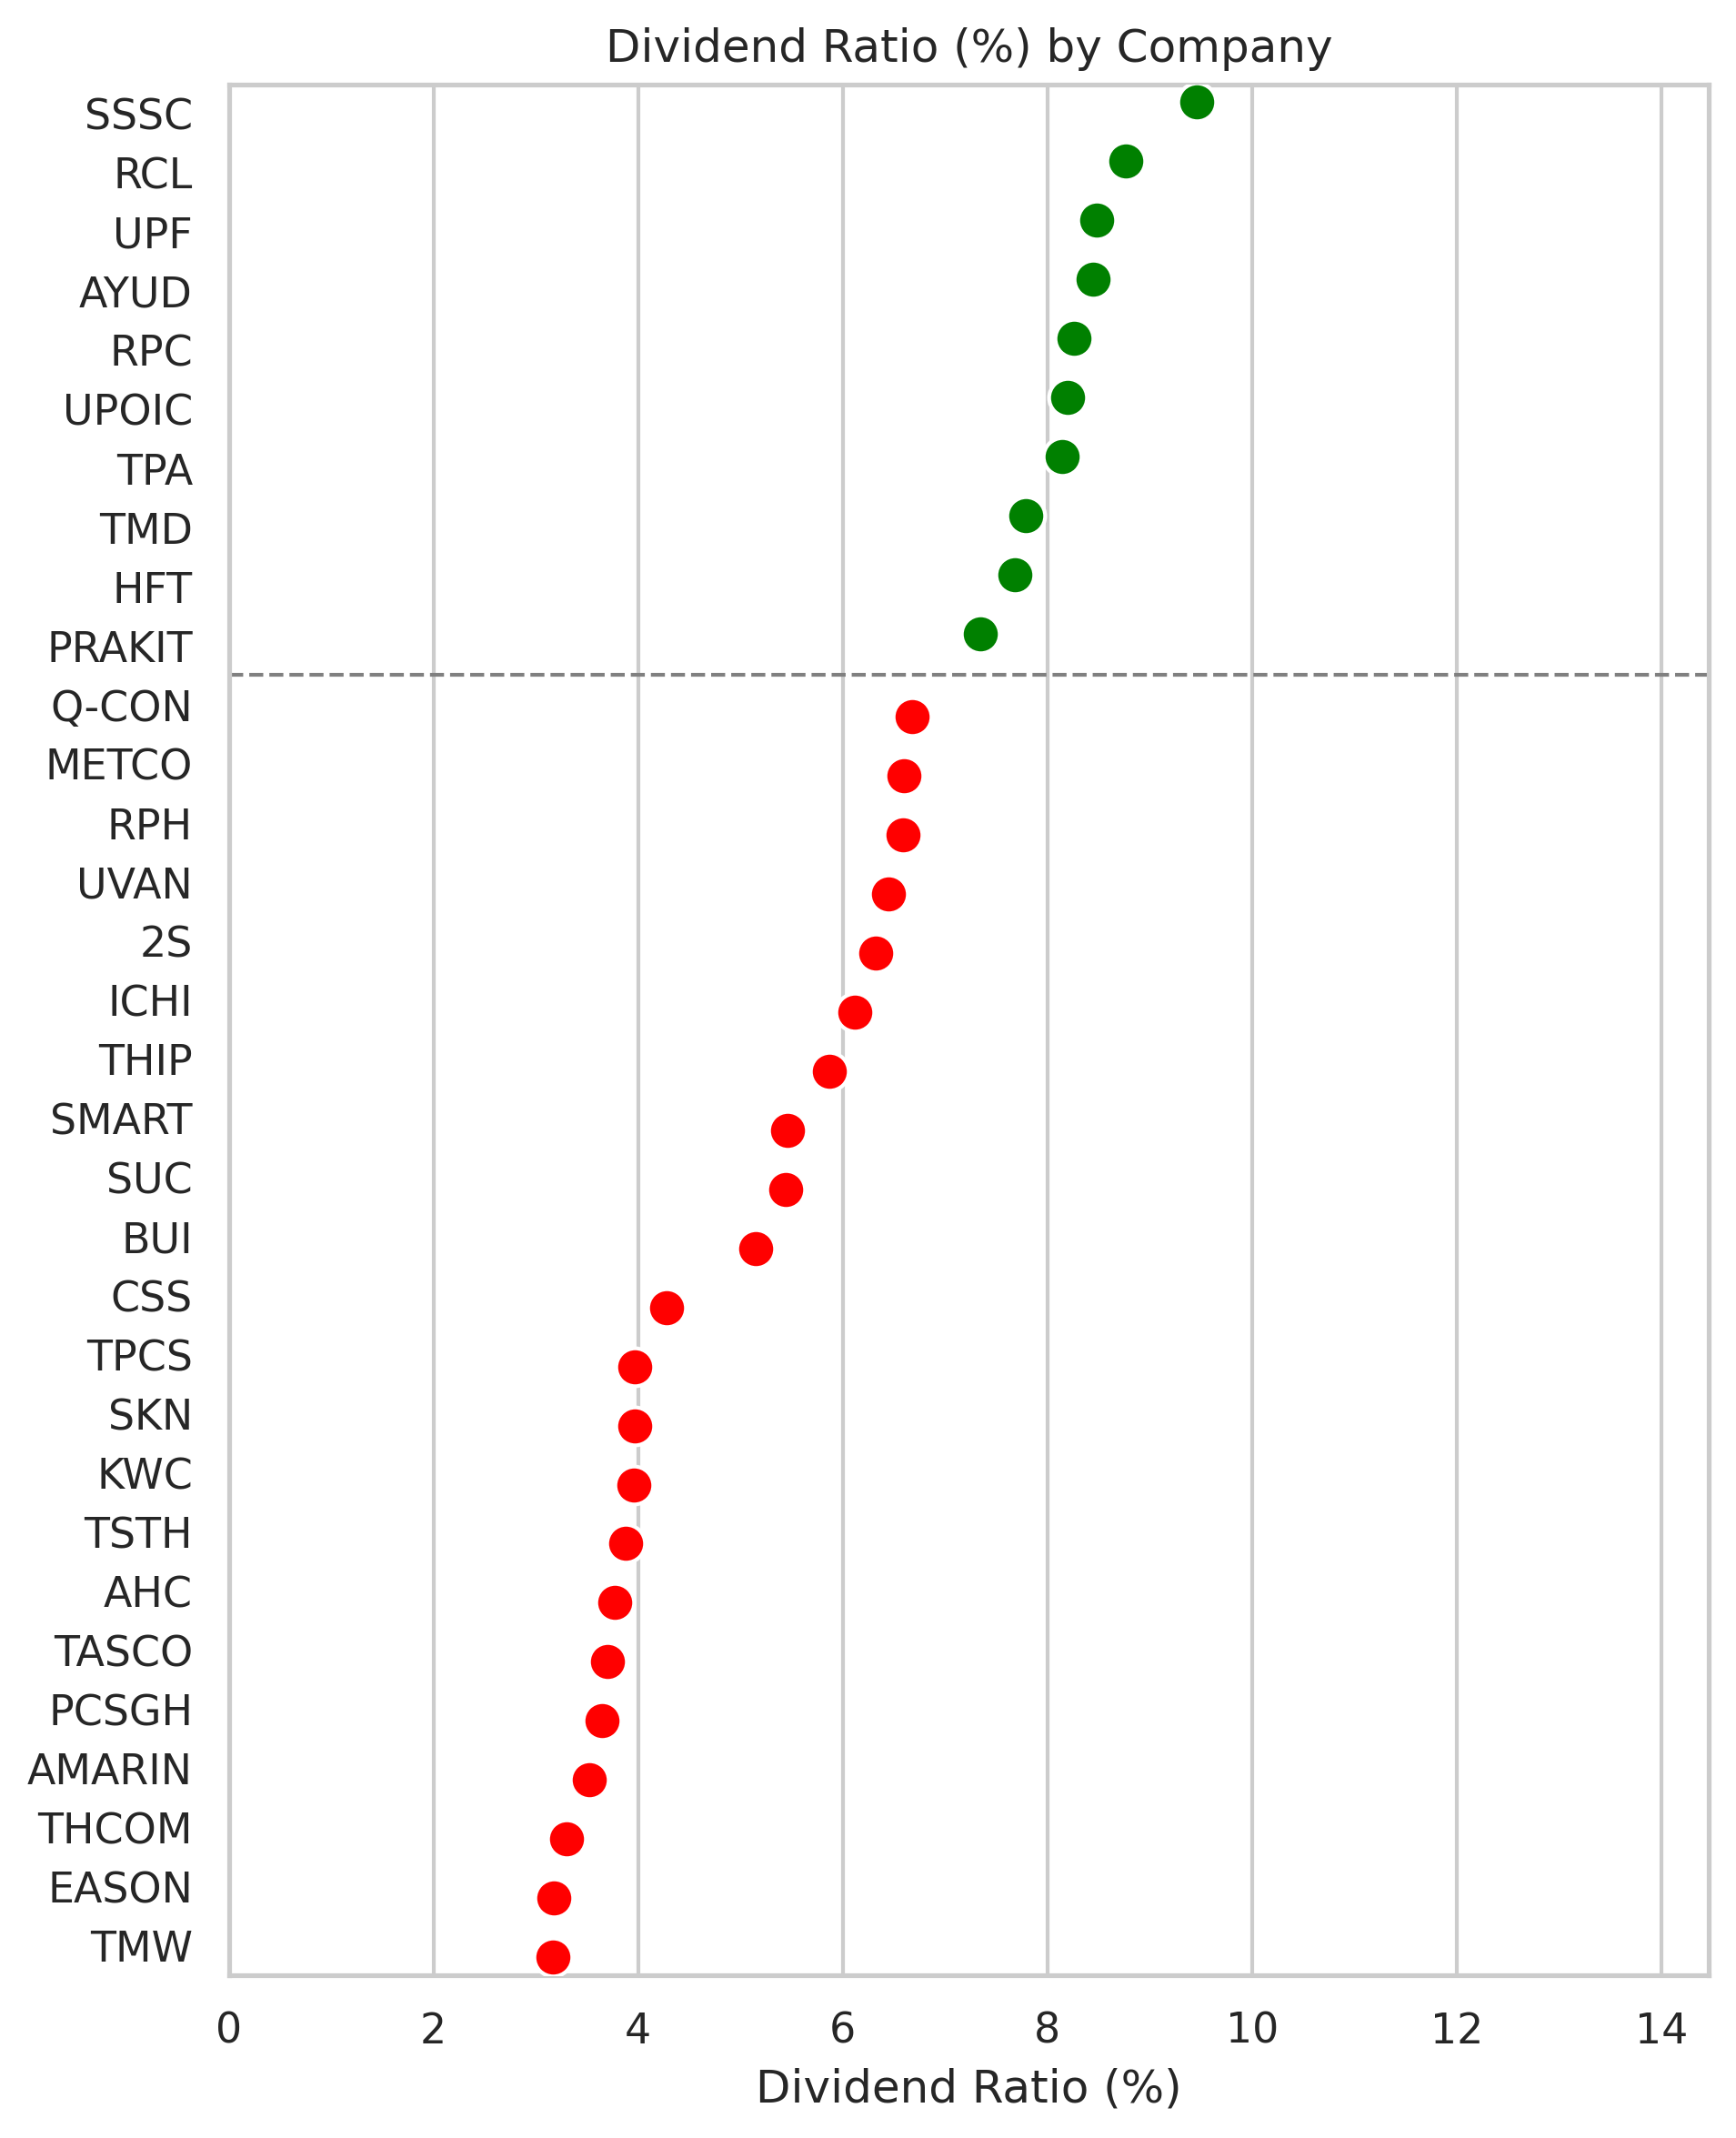

In [34]:
# Set the theme
sns.set_theme(style="whitegrid")

# Identify top 10 symbols based on div_ratio
top_10 = bfinal_chart.nlargest(10, 'div_ratio')['symbol'].values

# Create a color column
bfinal_chart['color'] = bfinal_chart['symbol'].apply(lambda x: 'green' if x in top_10 else 'red')

# Create the strip plot
plt.figure(figsize=(7, 9))
sns.stripplot(data=bfinal_chart.sort_values("div_ratio", ascending=False),
               y='symbol', x='div_ratio', size=10, orient='h',
               hue='color', dodge=True, linewidth=1, edgecolor="w",
               palette={'green': 'green', 'red': 'red'},
               legend=False)  # Remove legend

# Add a grey line to separate the 10th and 11th dots
plt.axhline(y=9.5, color='grey', linestyle='--', linewidth=1)  # Adjusted position

# Set labels and title
plt.xlim(0, bfinal_chart['div_ratio'].max() + 5)  # Adjust xlim as needed
plt.xlabel("Dividend Ratio (%)")
plt.ylabel("")
plt.title("Dividend Ratio (%) by Company")

# Show the plot
plt.show()

### Filter all criteria to get final list of stock

In [35]:
final_list = df_merged[(df_merged['avg_roe_3year']>= median_roe) &
              (df_merged['avg_roa_3year']>= median_roa) &
              (df_merged['de2022'] == 'less than or equal to 1') &
              (df_merged['rev_gth_2year']>= median_gth) &
              (df_merged['avg_npm_3year']>= median_npm) &
              ###(df_merged['2 years consecutive growth'] == 'positive')
              (df_merged['2022 oper cashflow growth'] == 'positive')
              ]

topten = final_list.sort_values(by='avg_npm_3year', ascending=False).head(10) #rank by highest avg_npm_3year
nat = topten.symbol.unique().tolist()
print("Final top ten list of stock sort by Average net profit margin")
display(topten)

Final top ten list of stock sort by Average net profit margin


,symbol,avg_roe_3year,avg_roa_3year,de2022,rev_gth_2year,avg_npm_3year,2022 oper cashflow growth
156,RCL,0.476627,0.326367,less than or equal to 1,0.789905,0.349196,positive
157,RJH,0.417366,0.263585,less than or equal to 1,0.379846,0.284240,positive
114,MEB,0.987477,0.454343,less than or equal to 1,0.314126,0.182707,positive
175,SICT,0.174391,0.140543,less than or equal to 1,0.336649,0.159463,positive
27,BE8,0.163303,0.075978,less than or equal to 1,0.671886,0.155331,positive
181,SMD,0.330966,0.199519,less than or equal to 1,0.846190,0.154151,positive
29,BH,0.128635,0.103855,less than or equal to 1,0.335432,0.144431,positive
235,UPOIC,0.180010,0.145902,less than or equal to 1,0.662040,0.141705,positive
100,KCE,0.149405,0.095252,less than or equal to 1,0.265712,0.128576,positive
1,AAI,0.223713,0.163529,less than or equal to 1,0.266884,0.128147,positive


---

In [36]:
eix = ['SSSC', 'RCL', 'UPF', 'AYUD', 'RPC', 'UPOIC', 'TPA', 'TMD', 'HFT', 'PRAKIT'] #eix
champ = ['AMATA', 'JCT', 'RCL', 'SCCC', 'SPC', 'STA', 'SUC', 'TASCO', 'TCAP', 'TMD'] #champ
#champ2 = ['AMATA','B-WORK','JCT','METCO','PSH','PTTEP','RCL','SCCC','SPC','STA','SUC','TASCO','TCAP','THIP','TMD','TOPP','UPF']

### Plot return on investment

#### Value Investment

Summary of investment by symbol (Value Investment)
start invest from Mar 2023 to Sep 2024 (total time: 1 year 6 months)


,initial portfolio,current portfolio,capital gain,%capital gain,accumulated dividend,%accumulated dividend yield,total return,ROI
symbol,,,,,,,,
TCAP,"100,000","122,873","22,873",22.9%,"15,822",15.8%,"38,695",38.7%
RCL,"100,000","119,387","19,387",19.4%,"18,792",18.8%,"38,180",38.2%
SUC,"100,000","123,398","23,398",23.4%,"11,304",11.3%,"34,702",34.7%
SCCC,"100,000","123,758","23,758",23.8%,"8,535",8.5%,"32,293",32.3%
TMD,"100,000","116,365","16,365",16.4%,"15,199",15.2%,"31,563",31.6%
STA,"100,000","120,568","20,568",20.6%,"9,645",9.6%,"30,214",30.2%
JCT,"100,000","112,251","12,251",12.3%,"11,504",11.5%,"23,755",23.8%
AMATA,"100,000","116,672","16,672",16.7%,"6,067",6.1%,"22,739",22.7%
TASCO,"100,000","108,387","8,387",8.4%,"13,041",13.0%,"21,428",21.4%


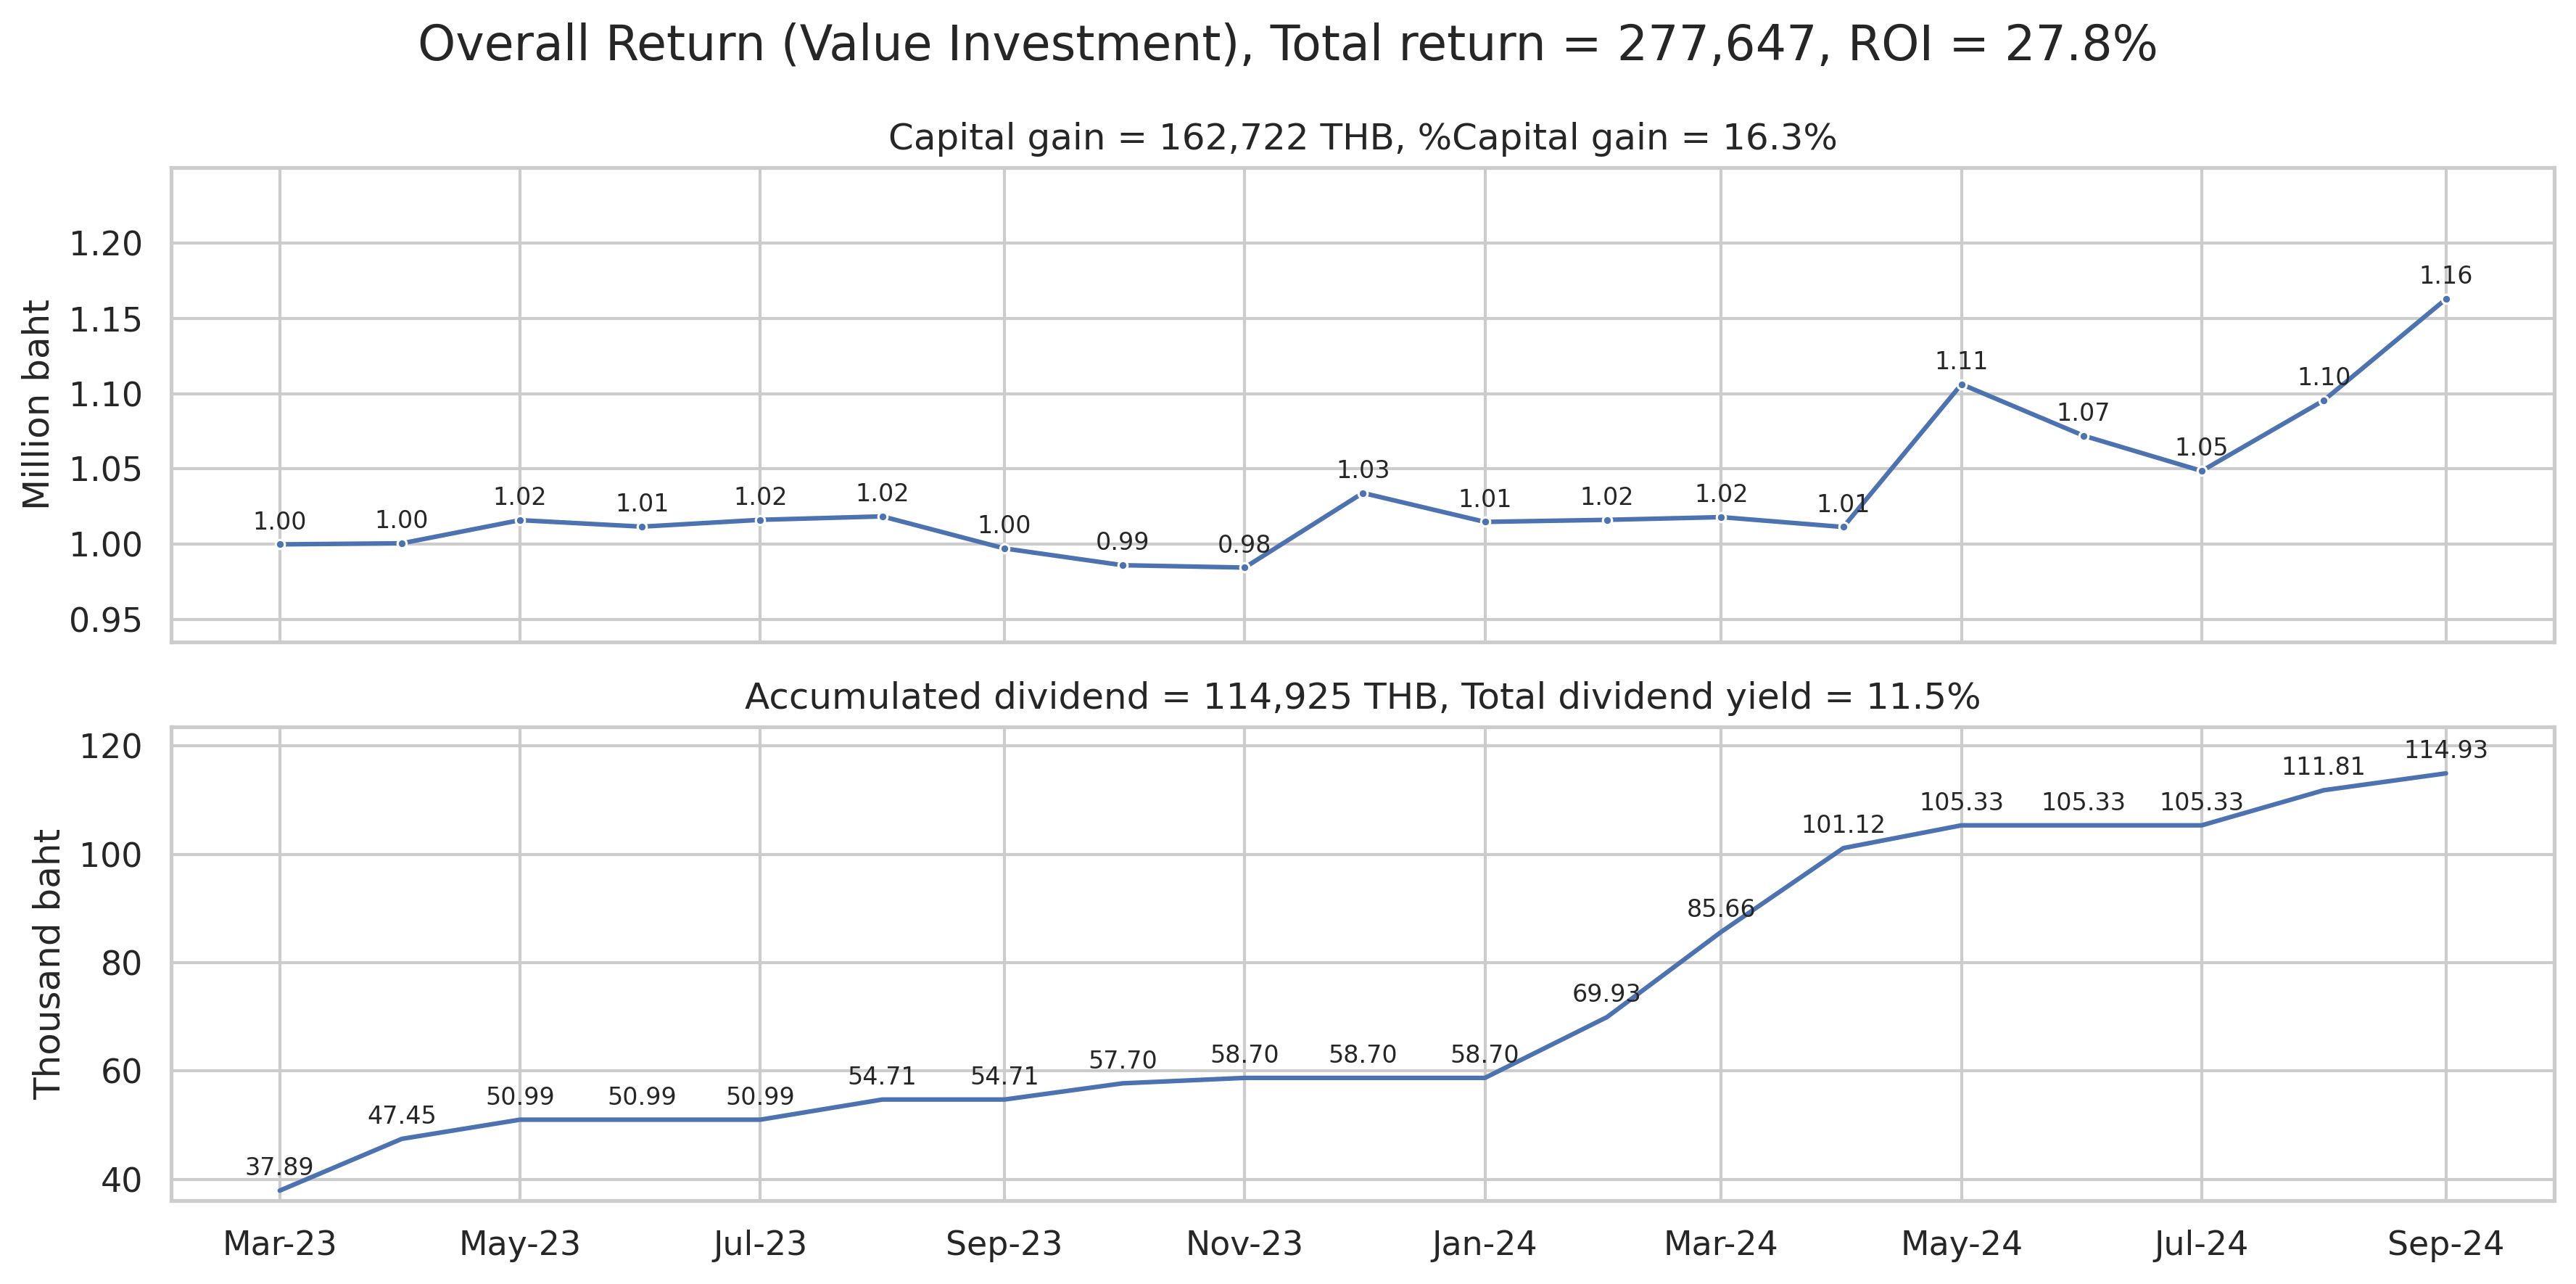

In [37]:
plot_roi(list_of_stock=champ, name='Value Investment', money=1000000, start_date='2023-03-01', end_date='2024-10-01')
display_summary(list_of_stock=champ, name="Value Investment", money = 1000000)

#### Growth Investment

Summary of investment by symbol (Growth Investment)
start invest from Mar 2023 to Sep 2024 (total time: 1 year 6 months)


,initial portfolio,current portfolio,capital gain,%capital gain,accumulated dividend,%accumulated dividend yield,total return,ROI
symbol,,,,,,,,
RCL,"100,000","119,387","19,387",19.4%,"18,792",18.8%,"38,180",38.2%
UPOIC,"100,000","118,451","18,451",18.5%,"13,460",13.5%,"31,911",31.9%
AAI,"100,000","116,361","16,361",16.4%,"11,900",11.9%,"28,261",28.3%
BH,"100,000","123,660","23,660",23.7%,"4,068",4.1%,"27,729",27.7%
RJH,"100,000","88,303","-11,697",-11.7%,"9,515",9.5%,"-2,182",-2.2%
KCE,"100,000","90,970","-9,030",-9.0%,"5,869",5.9%,"-3,161",-3.2%
MEB,"100,000","88,395","-11,605",-11.6%,"2,029",2.0%,"-9,577",-9.6%
SMD,"100,000","62,932","-37,068",-37.1%,"11,288",11.3%,"-25,780",-25.8%
SICT,"100,000","68,207","-31,793",-31.8%,568,0.6%,"-31,225",-31.2%


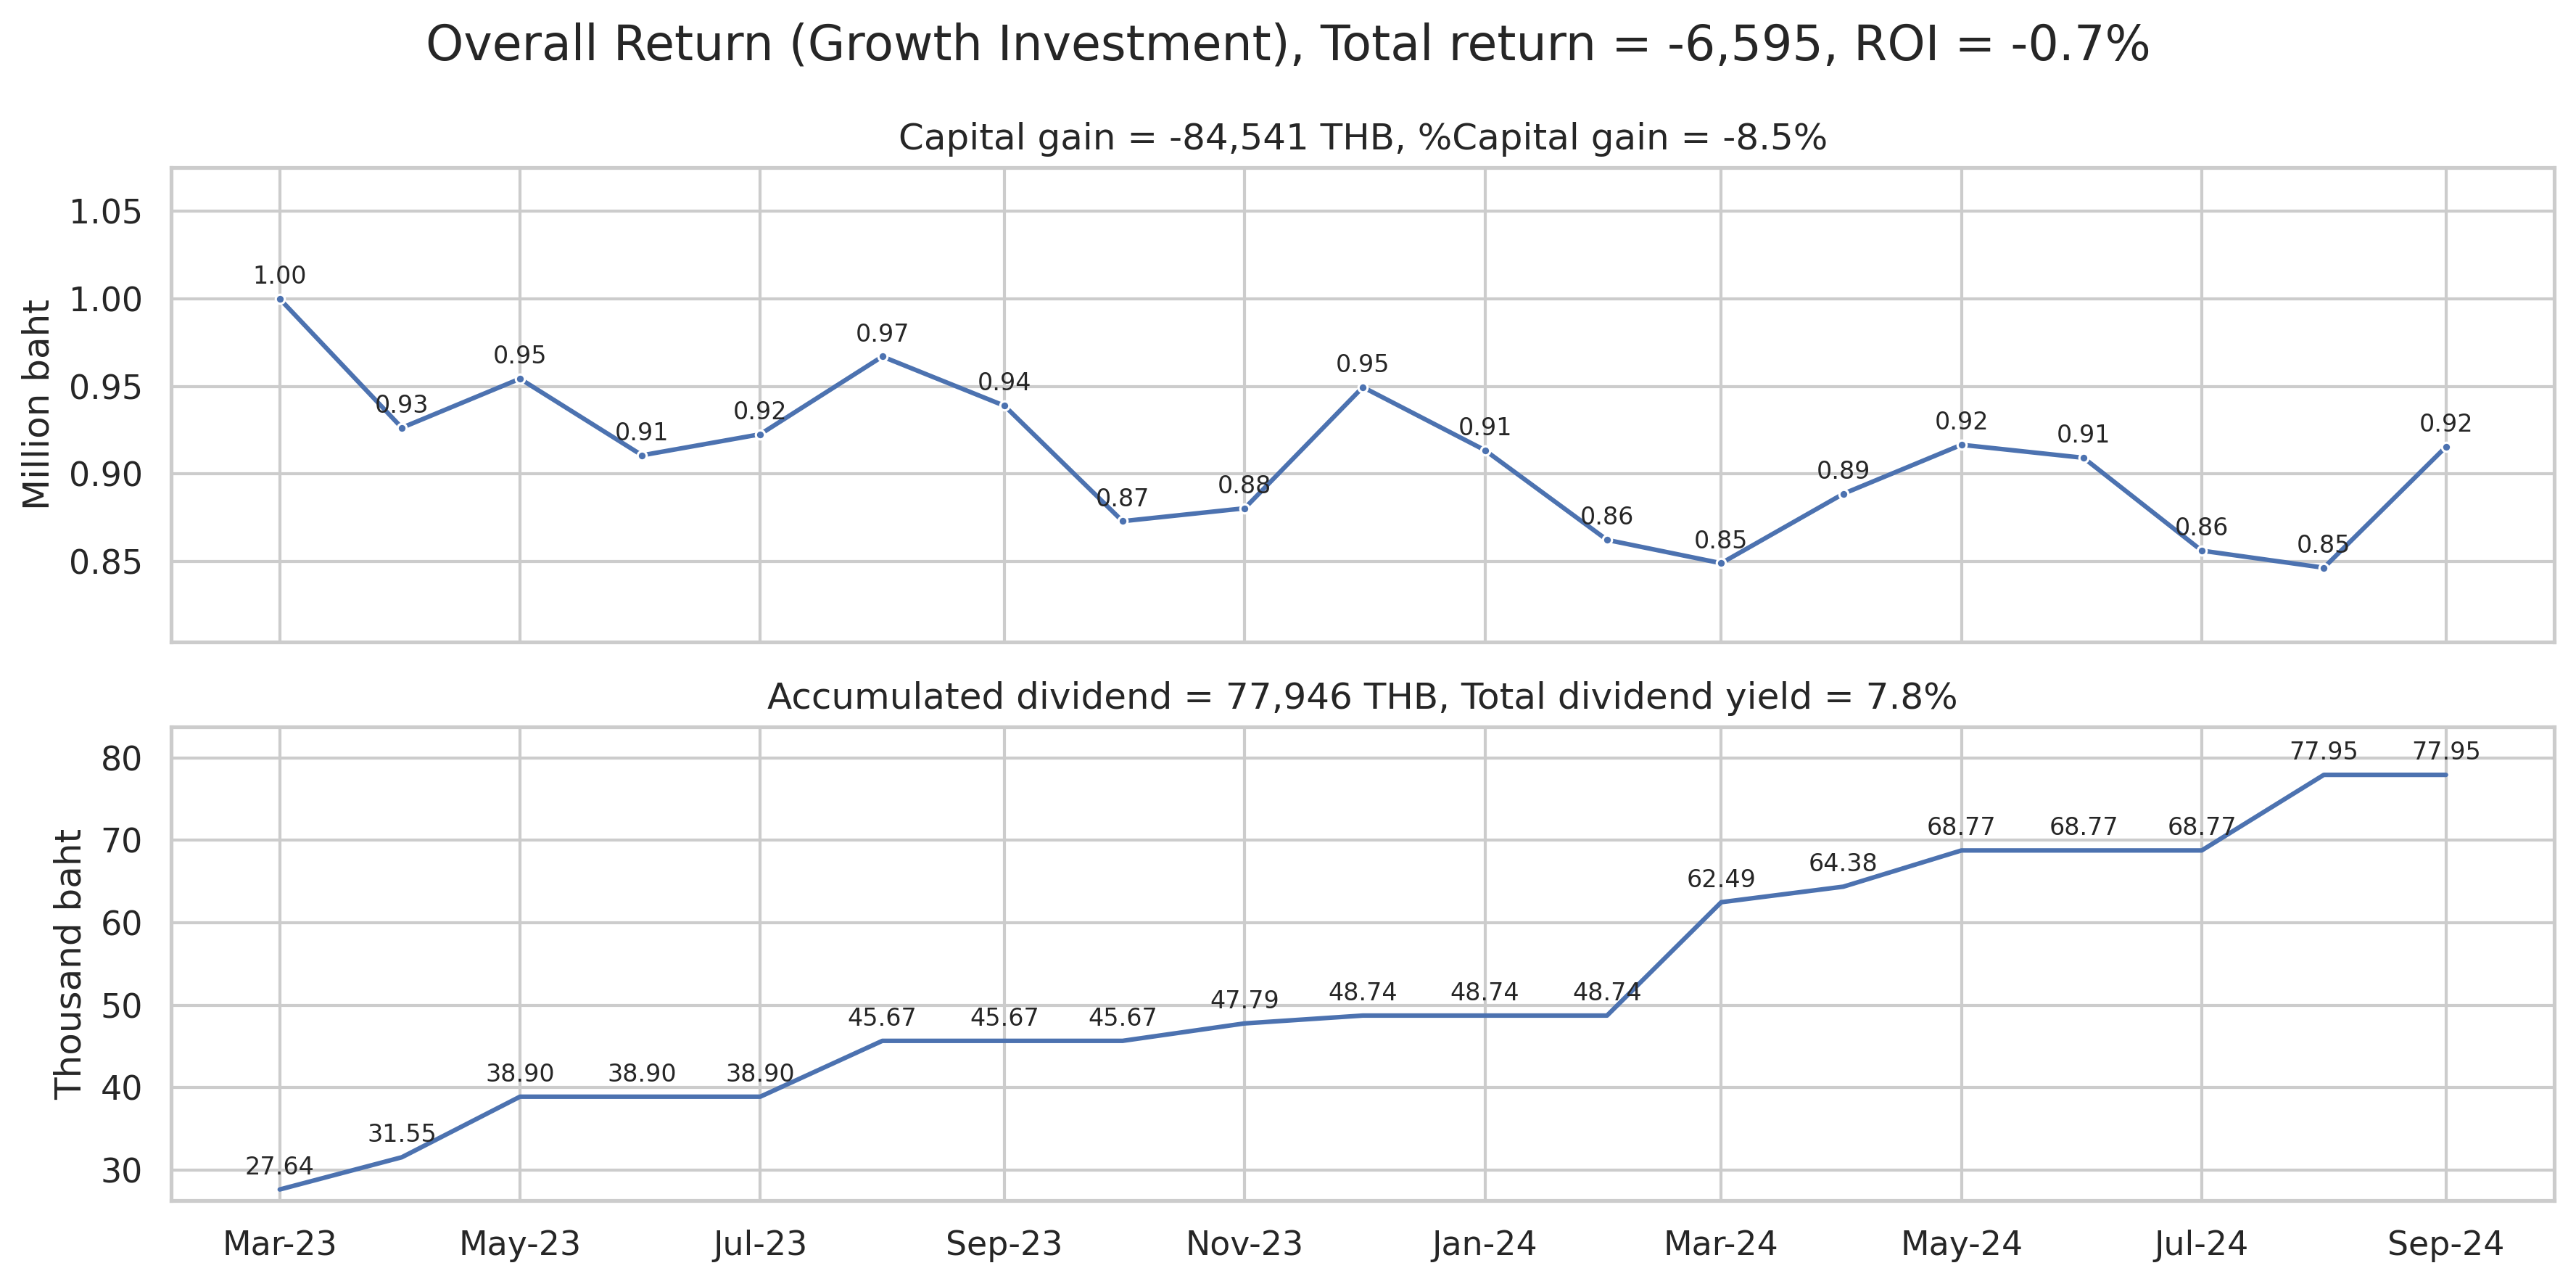

In [38]:
plot_roi(list_of_stock=nat, name='Growth Investment', money=1000000, start_date='2023-03-01', end_date='2024-10-01')
display_summary(list_of_stock=nat, name="Growth Investment", money = 1000000)

#### Dividend Income Strategy

Summary of investment by symbol (Dividend Income Strategy)
start invest from Mar 2023 to Sep 2024 (total time: 1 year 6 months)


,initial portfolio,current portfolio,capital gain,%capital gain,accumulated dividend,%accumulated dividend yield,total return,ROI
symbol,,,,,,,,
RCL,"100,000","119,387","19,387",19.4%,"18,792",18.8%,"38,180",38.2%
UPOIC,"100,000","118,451","18,451",18.5%,"13,460",13.5%,"31,911",31.9%
TMD,"100,000","116,365","16,365",16.4%,"15,199",15.2%,"31,563",31.6%
HFT,"100,000","107,694","7,694",7.7%,"22,186",22.2%,"29,880",29.9%
PRAKIT,"100,000","100,406",406,0.4%,"17,930",17.9%,"18,336",18.3%
SSSC,"100,000","90,626","-9,374",-9.4%,"15,369",15.4%,"5,994",6.0%
AYUD,"100,000","88,100","-11,900",-11.9%,"10,190",10.2%,"-1,711",-1.7%
TPA,"100,000","82,685","-17,315",-17.3%,"4,677",4.7%,"-12,638",-12.6%
RPC,"100,000","73,790","-26,210",-26.2%,"5,178",5.2%,"-21,032",-21.0%


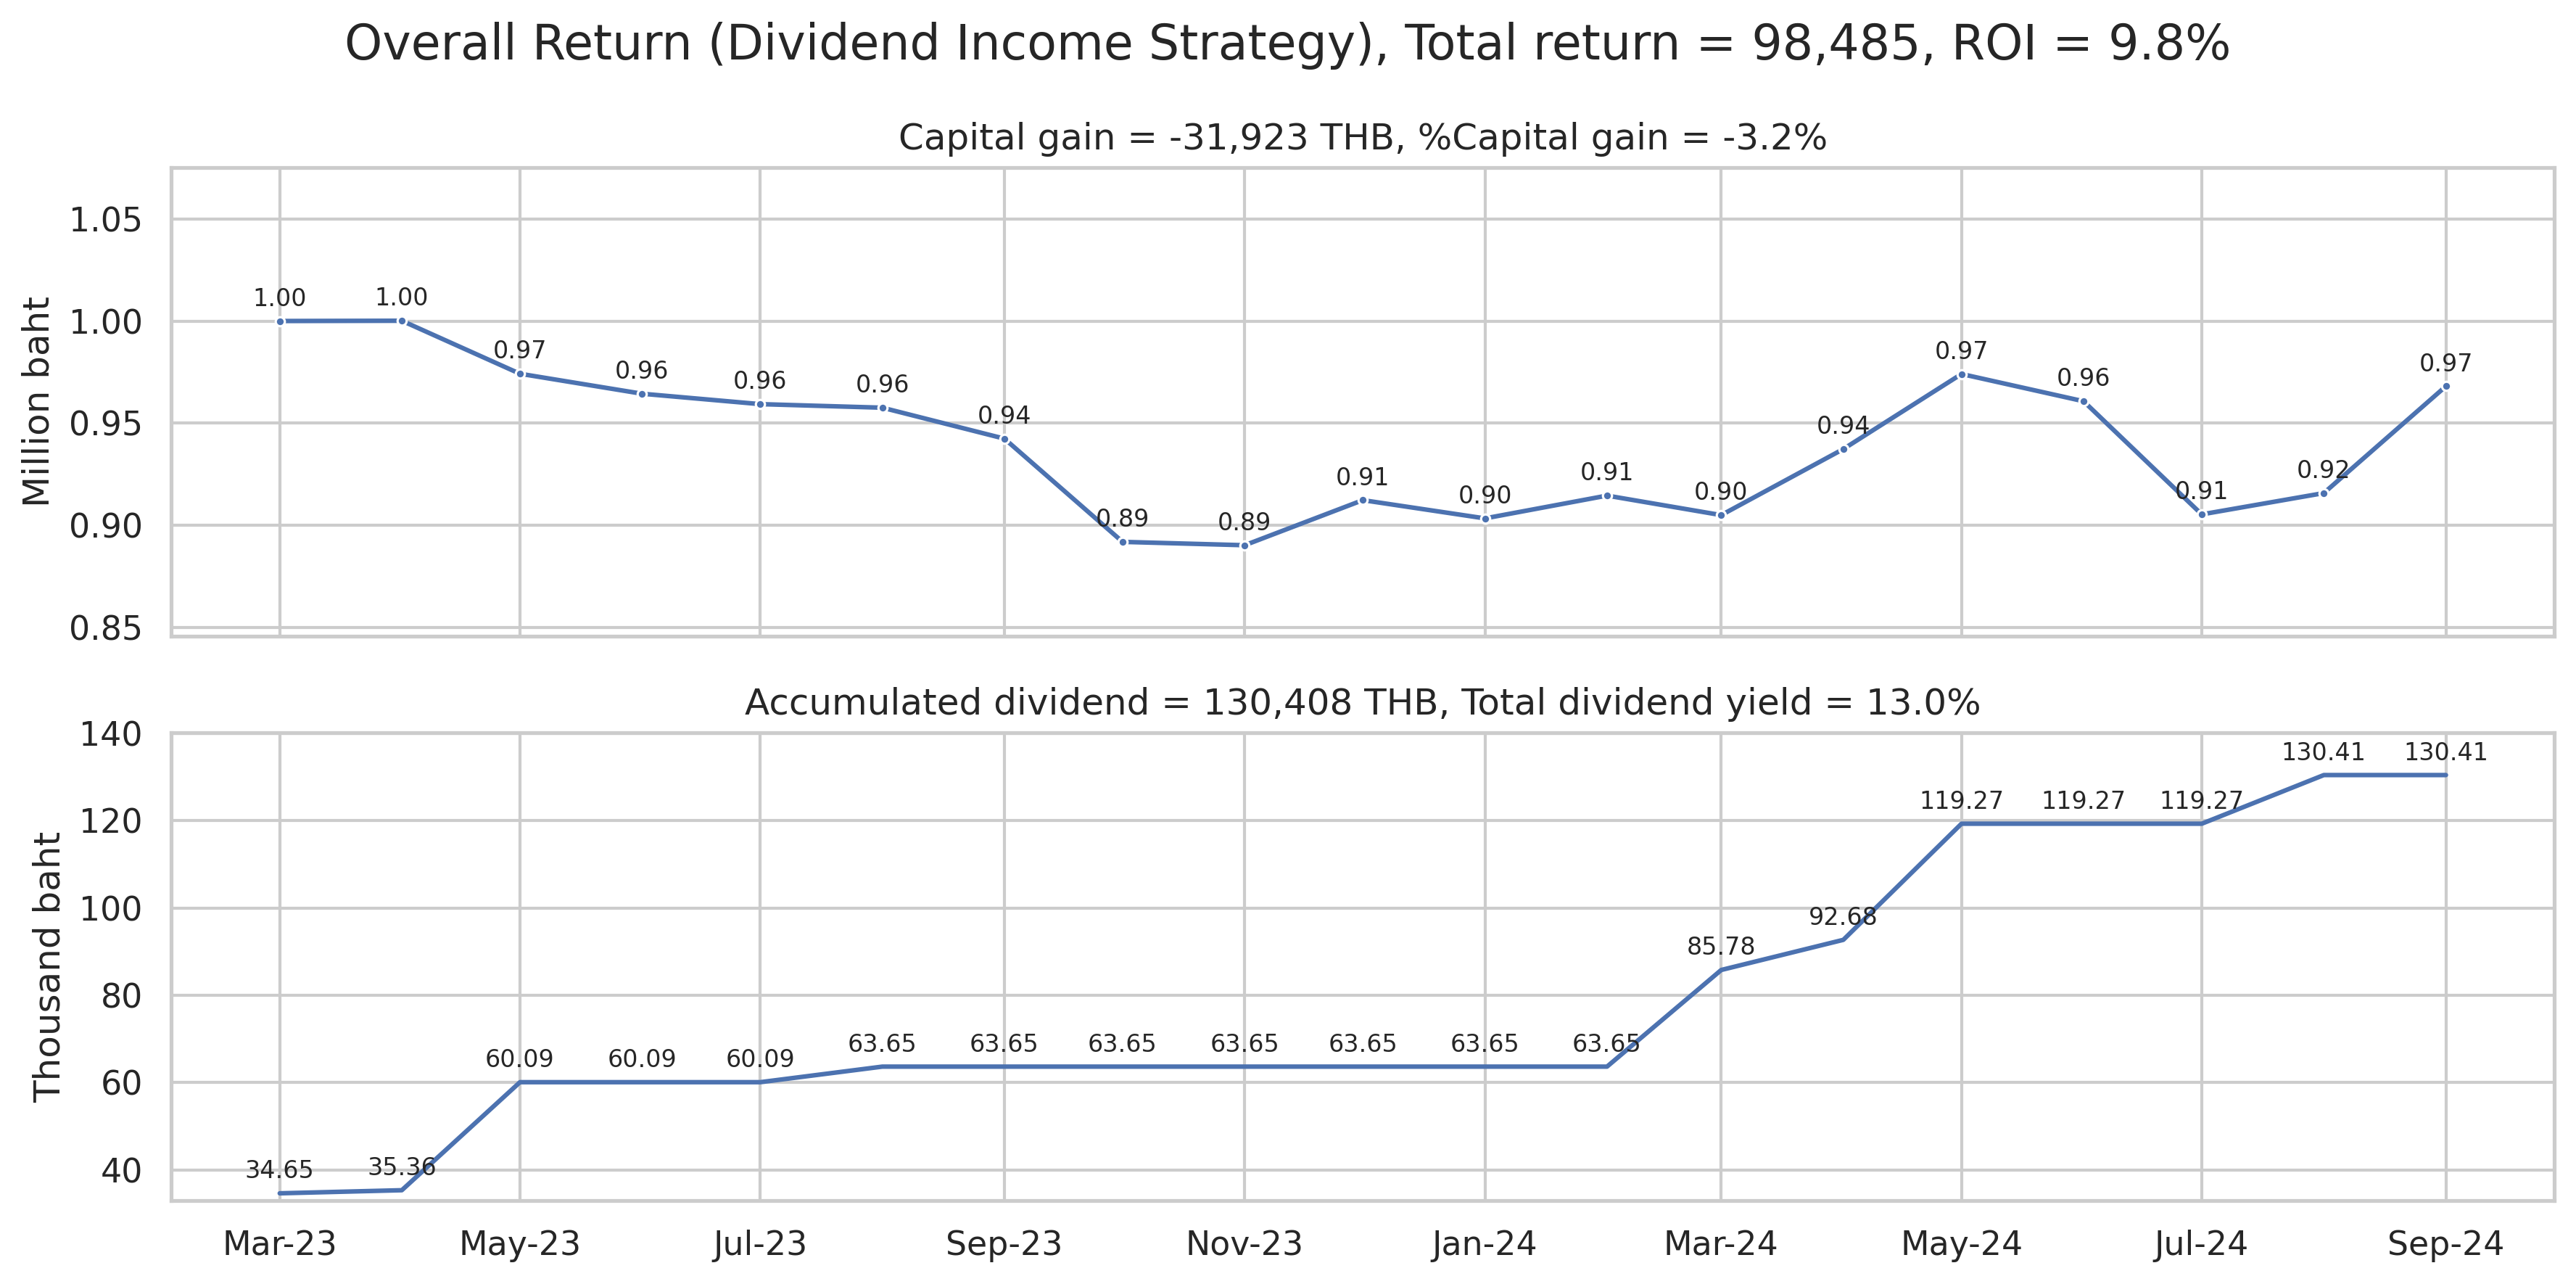

In [39]:
display_summary(list_of_stock=eix, name="Dividend Income Strategy", money = 1000000)
plot_roi(list_of_stock=eix, name='Dividend Income Strategy', money=1000000, start_date='2023-03-01', end_date='2024-10-01')